Nitrogen peak value near m/z = 28: 7.132e-07


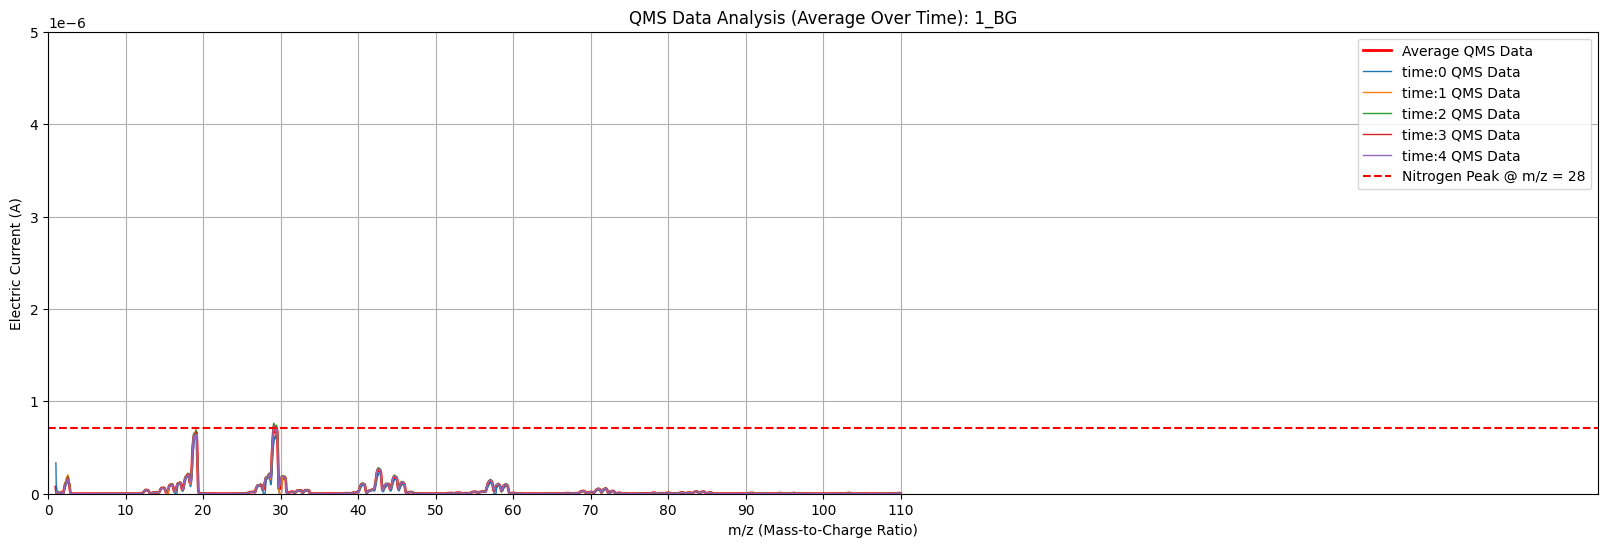

Nitrogen peak value near m/z = 28: 1.0733333333333332e-06


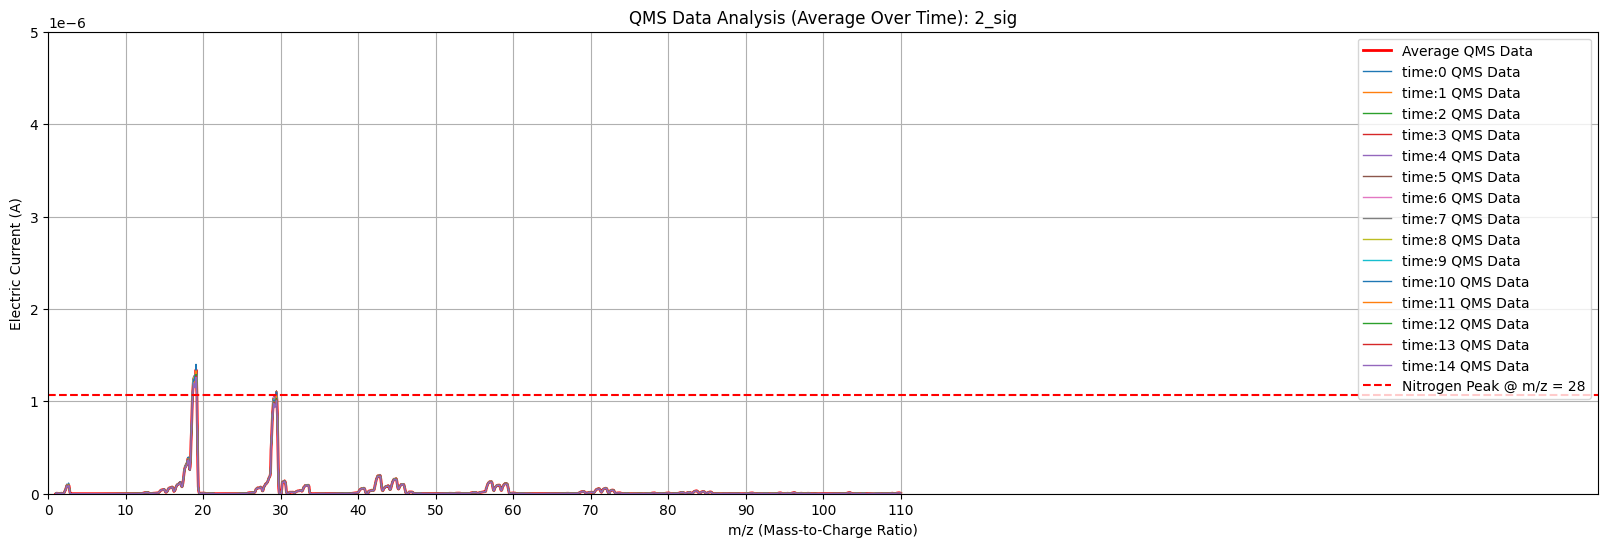

Nitrogen peak value near m/z = 28: 6.888e-07


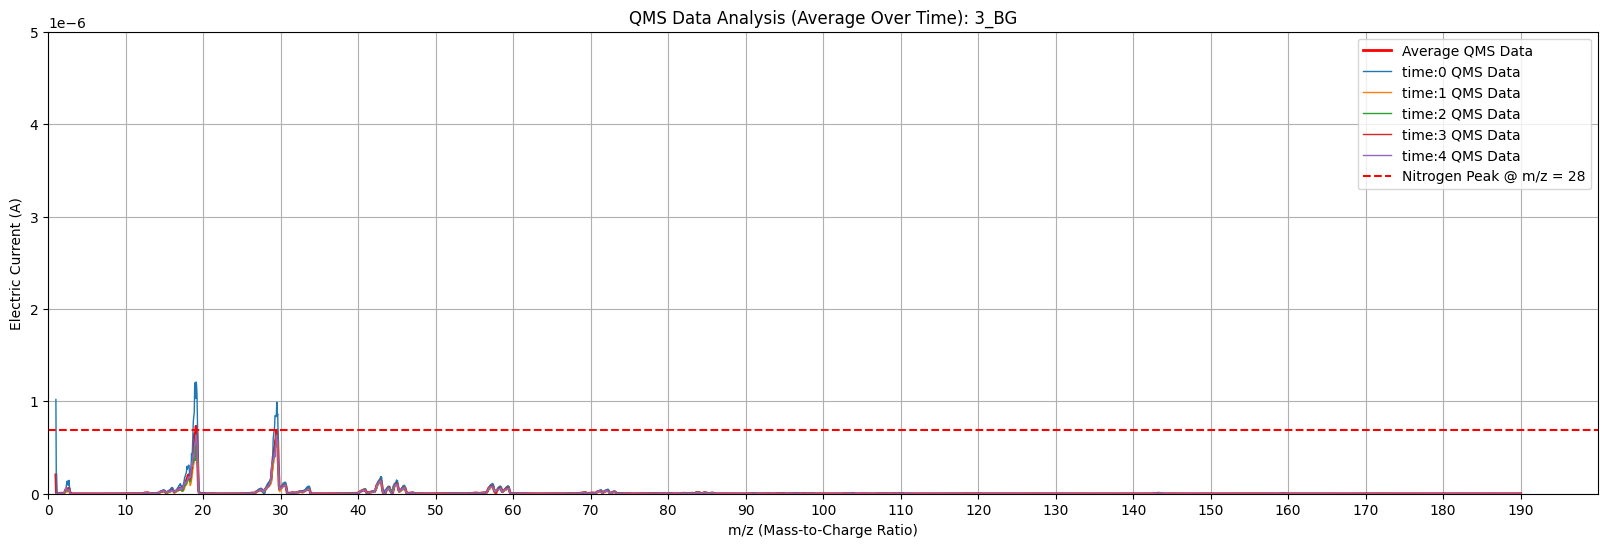

Nitrogen peak value near m/z = 28: 6.340000000000001e-07


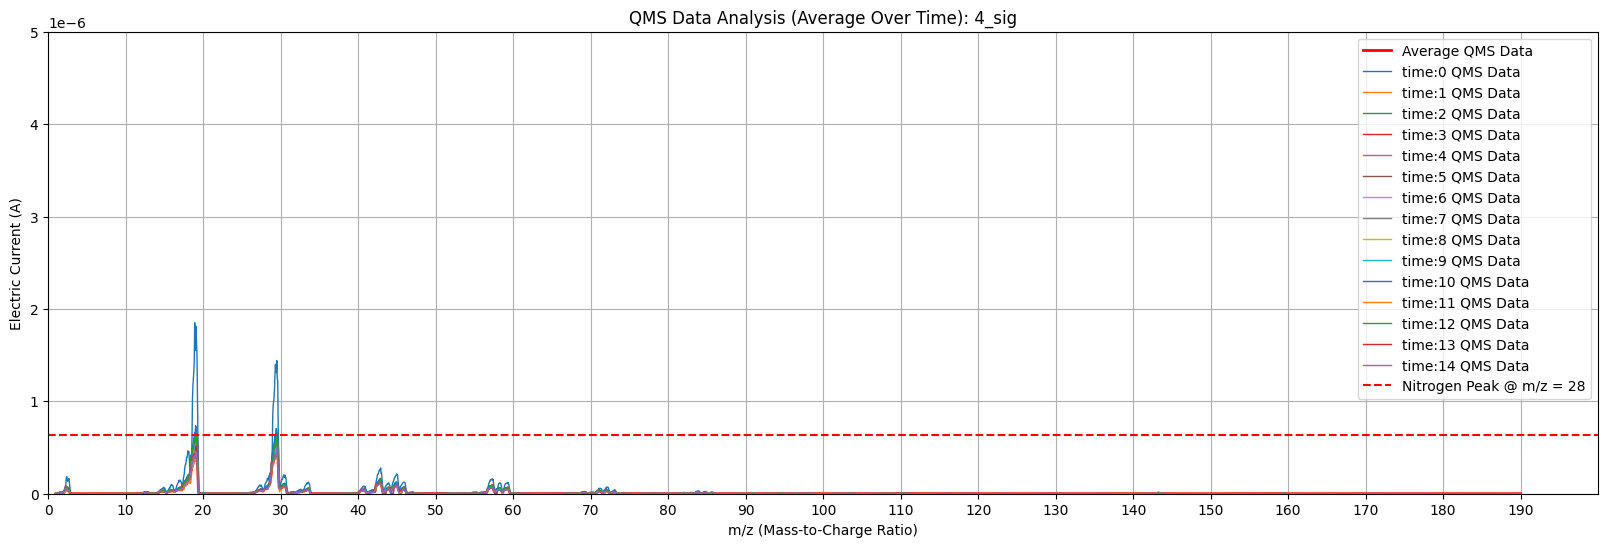

Nitrogen peak value near m/z = 28: 1.938e-06


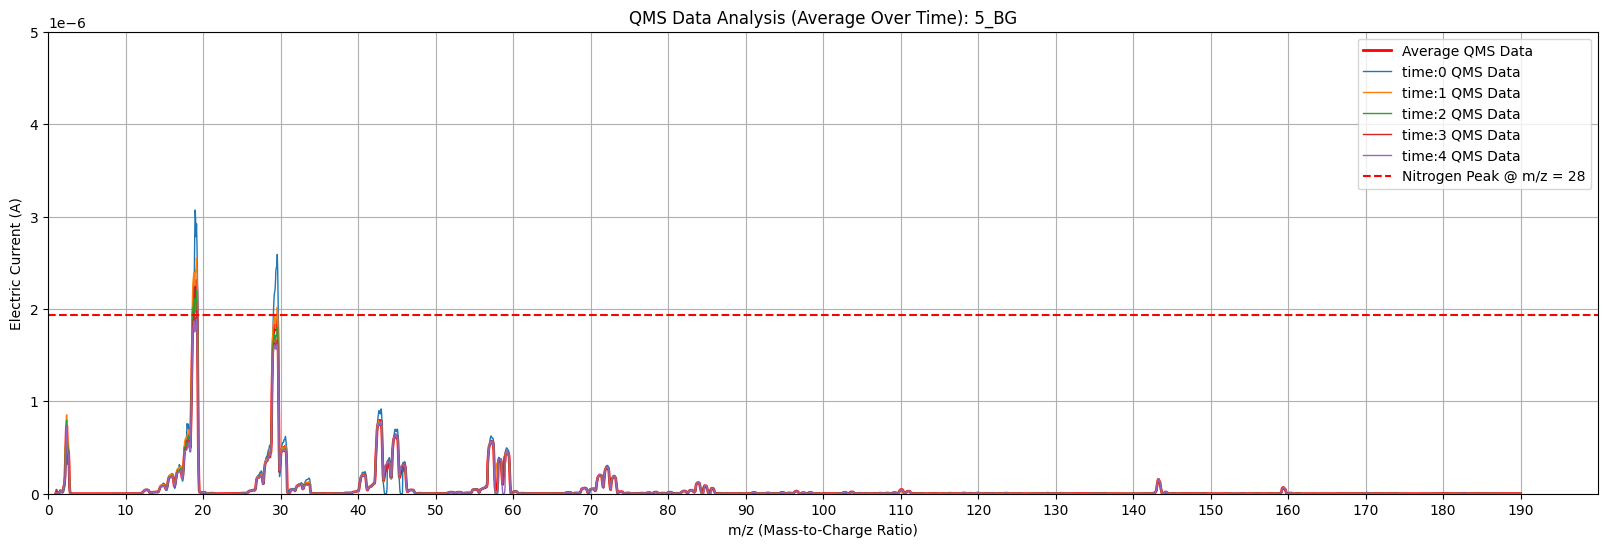

Nitrogen peak value near m/z = 28: 1.7971428571428575e-06


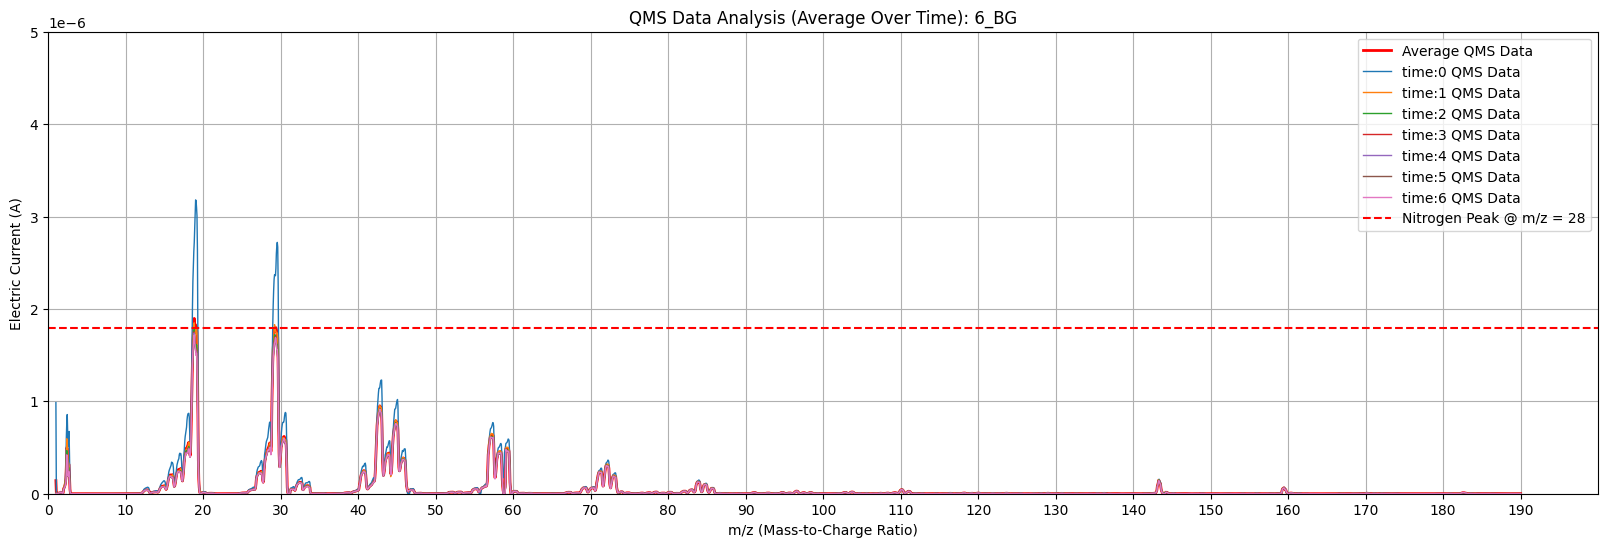

Nitrogen peak value near m/z = 28: 1.7406666666666663e-06


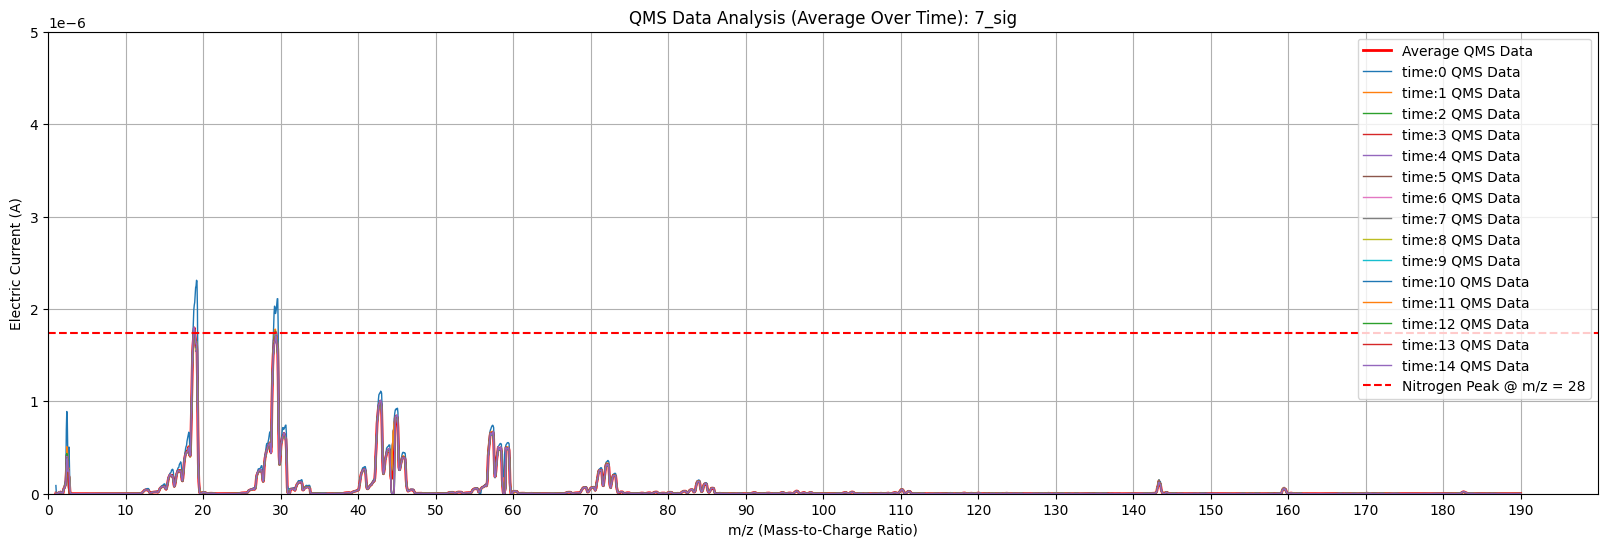

Nitrogen peak value near m/z = 28: 1.6713333333333334e-06


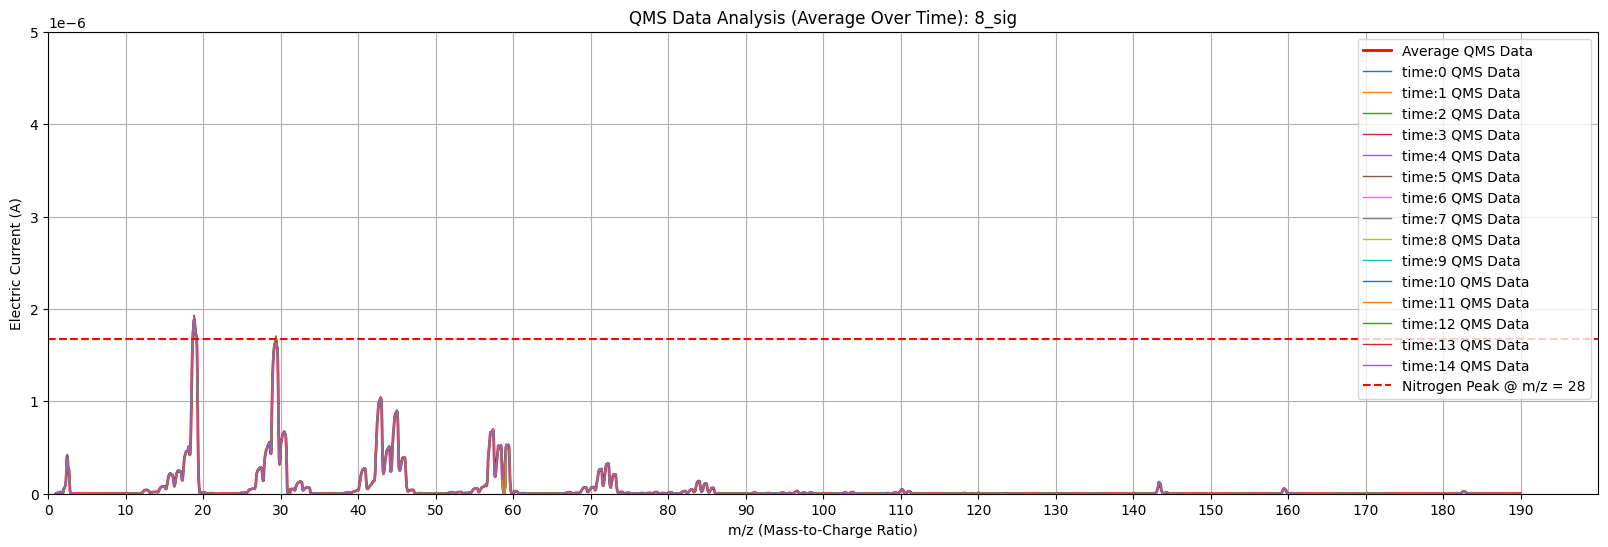

Nitrogen peak value near m/z = 28: 1.5966666666666665e-06


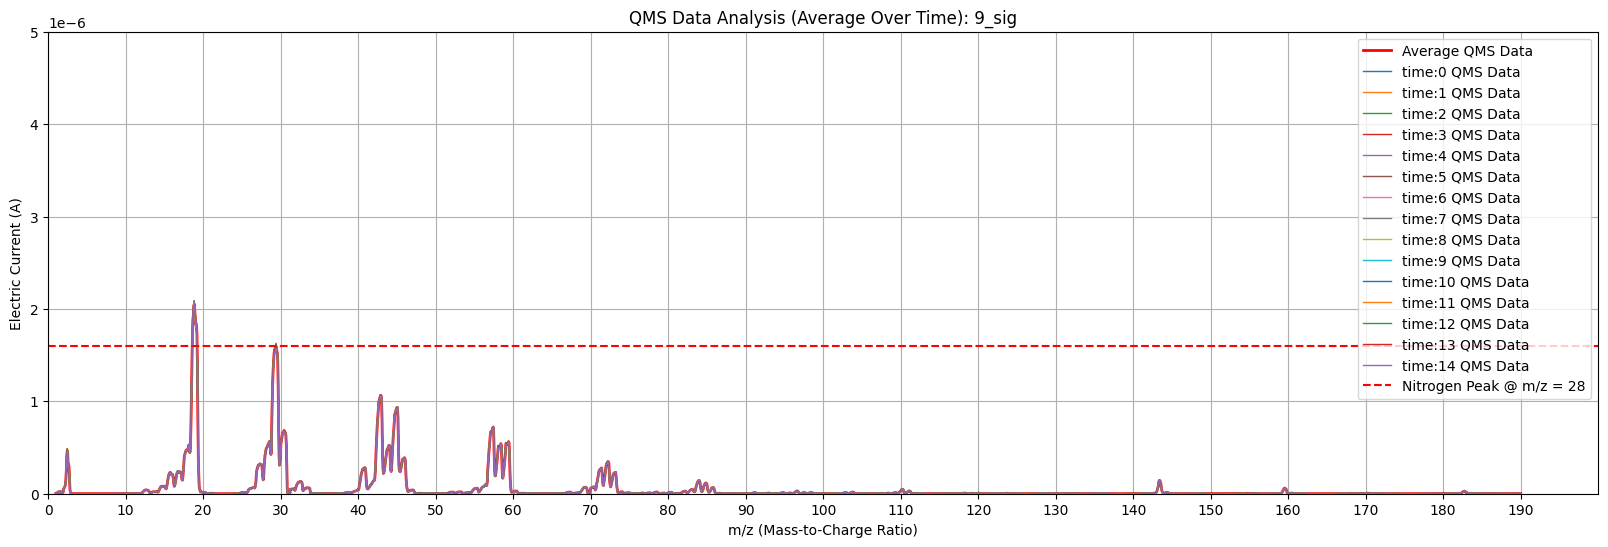

Nitrogen peak value near m/z = 28: 1.8960000000000001e-06


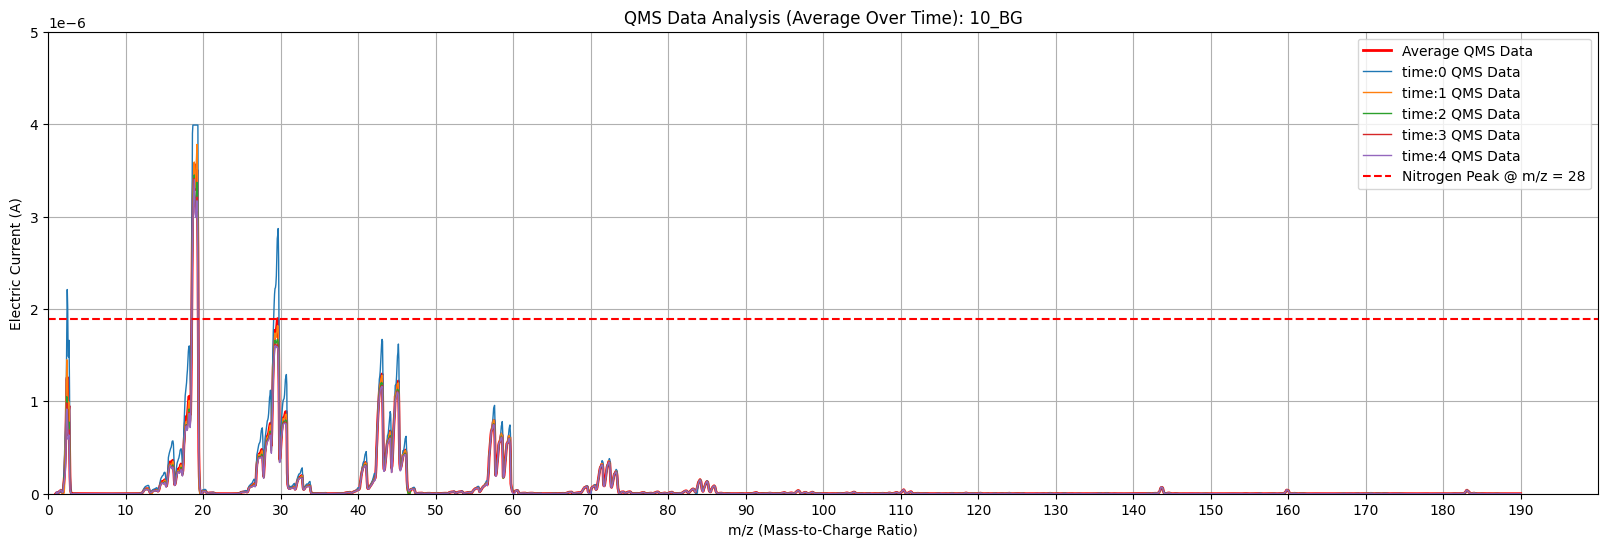

Nitrogen peak value near m/z = 28: 1.5520000000000001e-06


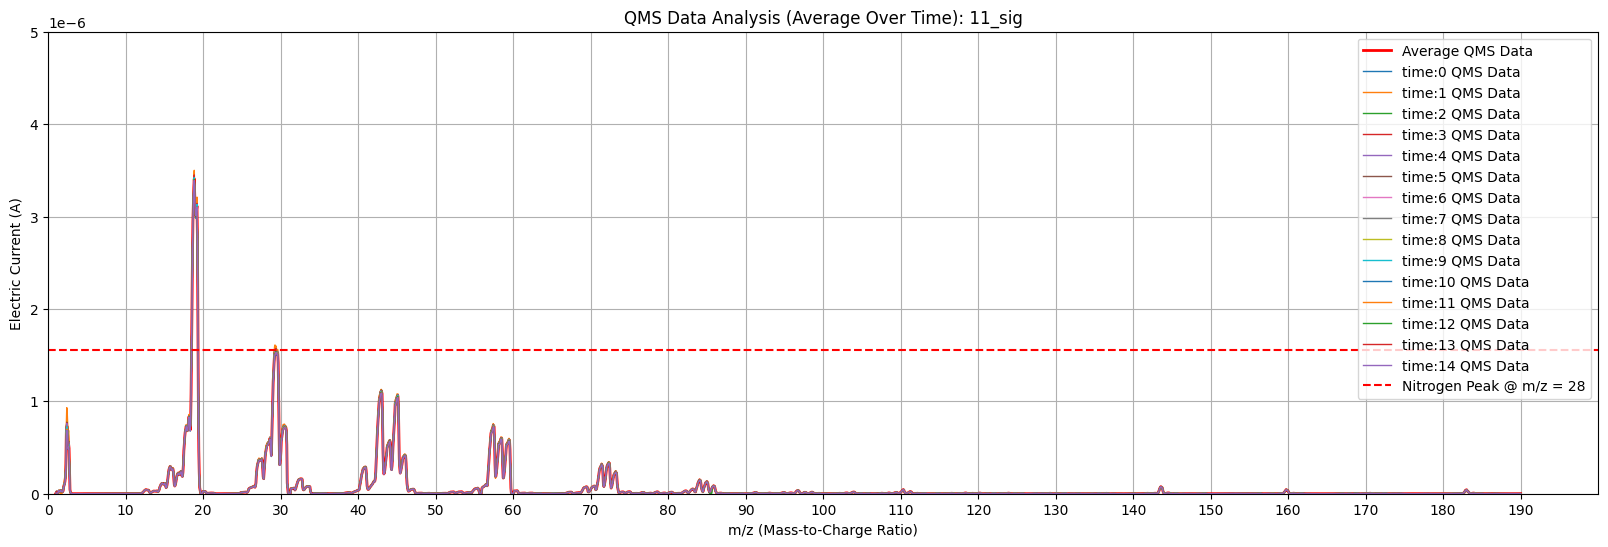

Nitrogen peak value near m/z = 28: 1.4639999999999999e-06


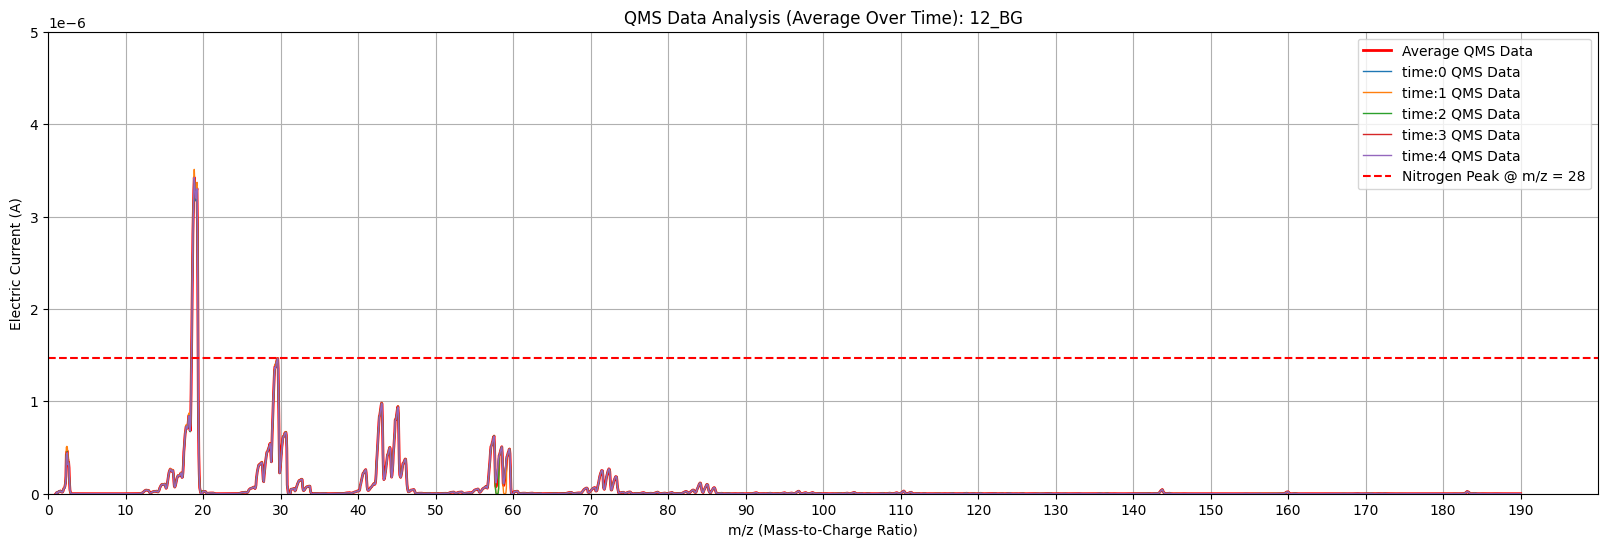

Nitrogen peak value near m/z = 28: 1.4599999999999998e-06


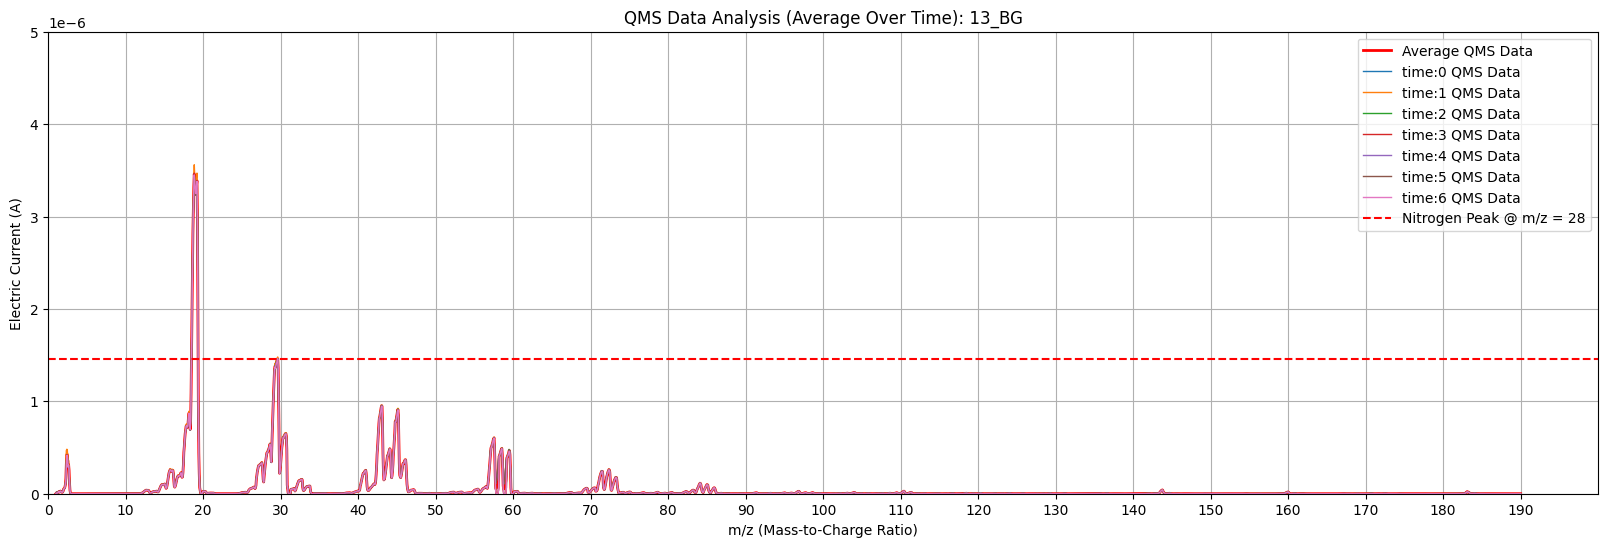

Nitrogen peak value near m/z = 28: 1.4566666666666666e-06


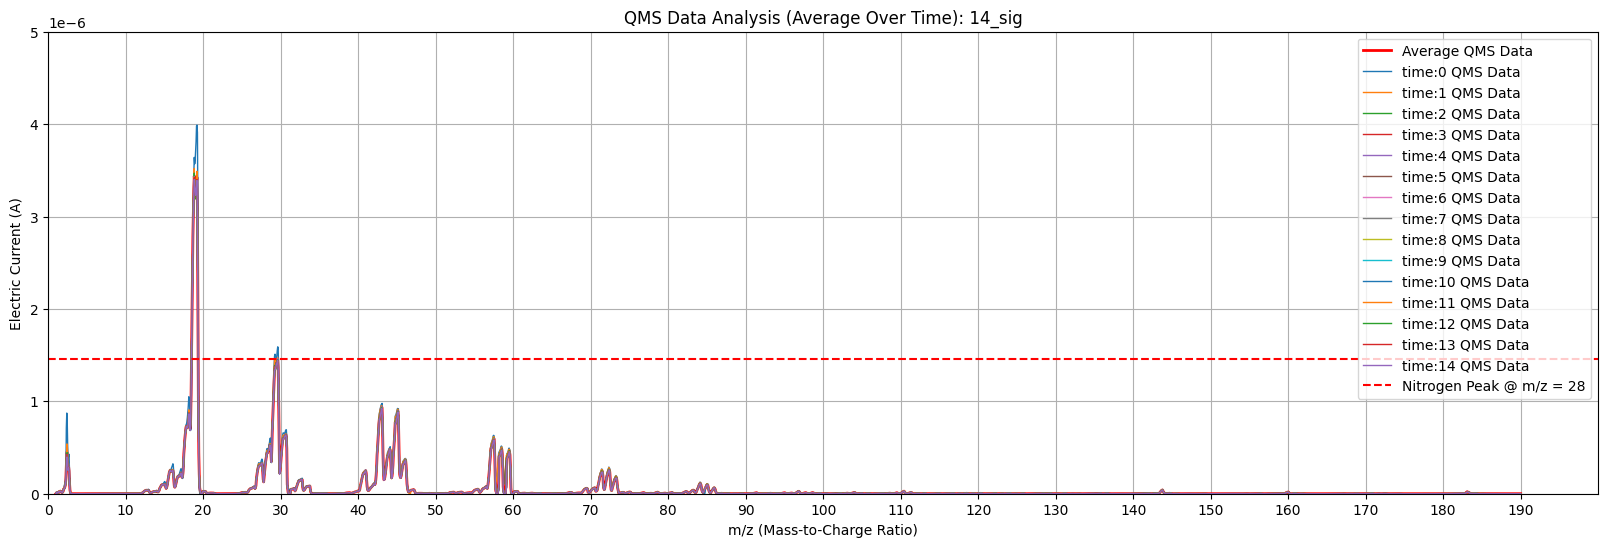

Nitrogen peak value near m/z = 28: 1.4213333333333332e-06


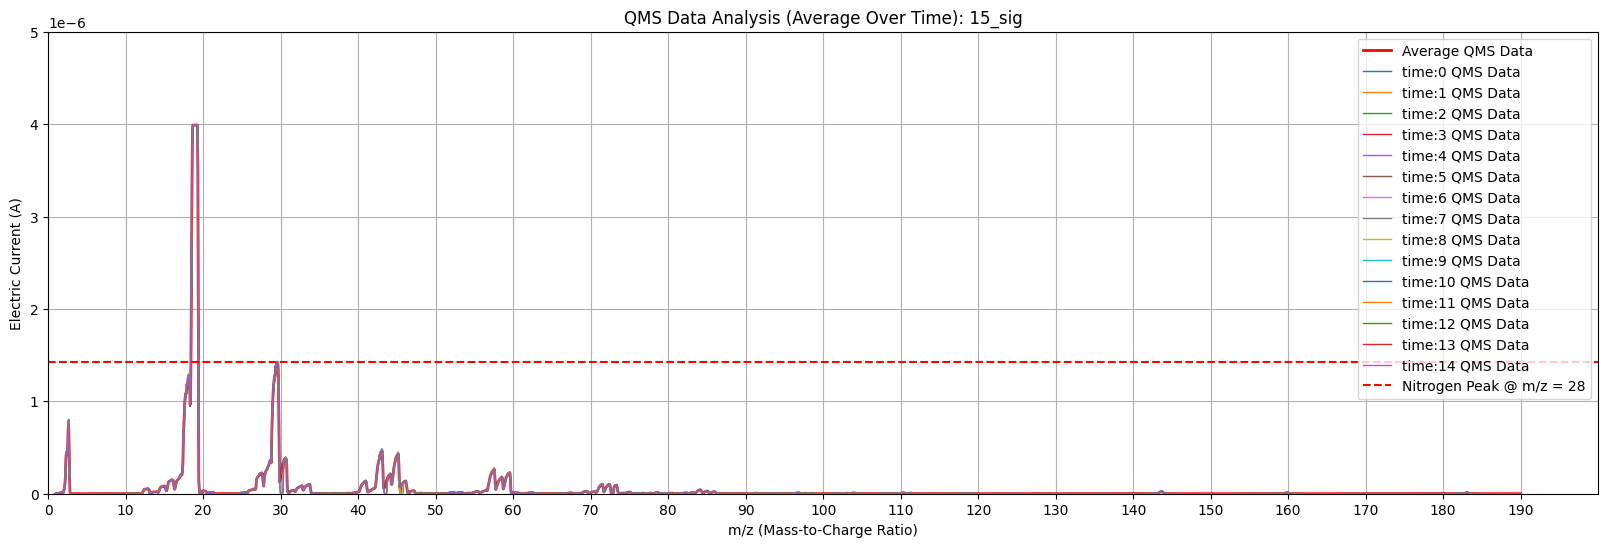

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# CSVファイルを読み込む
# file_path = './250117/1_BG.CSV'  # 実際のCSVファイルパスに置き換えるのだ！
dir_name = './250117/'  # 実際のCSVファイルパスに置き換えるのだ！
filename = ['1_BG','2_sig','3_BG','4_sig','5_BG','6_BG','7_sig','8_sig','9_sig','10_BG','11_sig','12_BG','13_BG','14_sig','15_sig']

for j in np.arange(0,len(filename),1):
    file_path = dir_name + filename[j] + '.csv'
    # 18列を固定で読み込むように設定
    col_names = [f"col_{i}" for i in range(18)]  # 固定で18列の名前を作成
    data = pd.read_csv(
        file_path,
        header=None,
        encoding='cp932',
        sep=',',
        names=col_names,  # 18列分の名前を指定
        skip_blank_lines=False  # 空行をスキップしない
    )
    
    # データフレーム全体を確認
    # print(data.head(8))  
    # 測定範囲を抽出
    start_mz = int(data.iloc[5, 0])  # A6の値
    end_mz = int(data.iloc[5, 1])  # B6の値
    
    # 電流値を二次元配列に格納
    electric_current_values = []
    current_time_data = []
    
    # 8行目以降をループして各時刻のデータを取得
    i = 8
    while i < len(data):
        # 時刻の行をスキップ（列数が1になっている行を判定）
        if data.iloc[i].count() == 1:
            i += 1
            electric_current_values.append(current_time_data)
            current_time_data = []
            continue
    
        # データの範囲を取得
        current_block = data.iloc[i,0:17].values  # 18列分のデータを取得
        current_block = pd.to_numeric(current_block, errors='coerce')  # 数値に変換
        current_time_data = np.concatenate([current_time_data, current_block.flatten()])
    
        # 次のブロックへ
        i += 1
    
    
    # 最後のデータを追加
    if len(current_time_data) > 0:
        electric_current_values.append(current_time_data)
    
    # 各時刻のデータを平均化
    electric_current_averages = np.mean(electric_current_values, axis=0)

    # 測定範囲のm/z配列を作成
    mz_values = np.linspace(start_mz, end_mz, len(electric_current_values[0]))
    # m/z = 28付近の窒素ピーク値を抽出
    mz_target = 28
    mz_tolerance = 2  # 許容範囲
    target_index = np.where((mz_values >= mz_target - mz_tolerance) & (mz_values <= mz_target + mz_tolerance))[0]
    nitrogen_peak_value = max(electric_current_averages[target_index])
    print(f"Nitrogen peak value near m/z = {mz_target}: {nitrogen_peak_value}")
    
    # 平均値をプロット
    plt.figure(figsize=(20, 6))
    plt.plot(mz_values, electric_current_averages, label="Average QMS Data", linewidth=2, color='red')
    for i in np.arange(0,len(electric_current_values),1):
        plt.plot(mz_values, electric_current_values[i], linewidth=1, label="time:{} QMS Data".format(i))
    
    plt.axhline(y=nitrogen_peak_value, color='r', linestyle='--', label=f"Nitrogen Peak @ m/z = {mz_target}")

    plt.ylim([0,5e-6])
    plt.xlim([0,200])
    plt.xlabel("m/z (Mass-to-Charge Ratio)")
    plt.ylabel("Electric Current (A)")
    plt.title("QMS Data Analysis (Average Over Time): {}".format(filename[j]))
    plt.xticks(np.arange(0, end_mz+10, 10))  # X軸を10刻みに設定
    plt.grid(True)
    plt.legend()
    plt.show()
    
    # # グラフを保存
    # output_filename = filename[j] + '_average_plot.png'
    # output_path = os.path.join('./', output_filename)
    # plt.savefig(output_path, dpi=300)
    # plt.show()


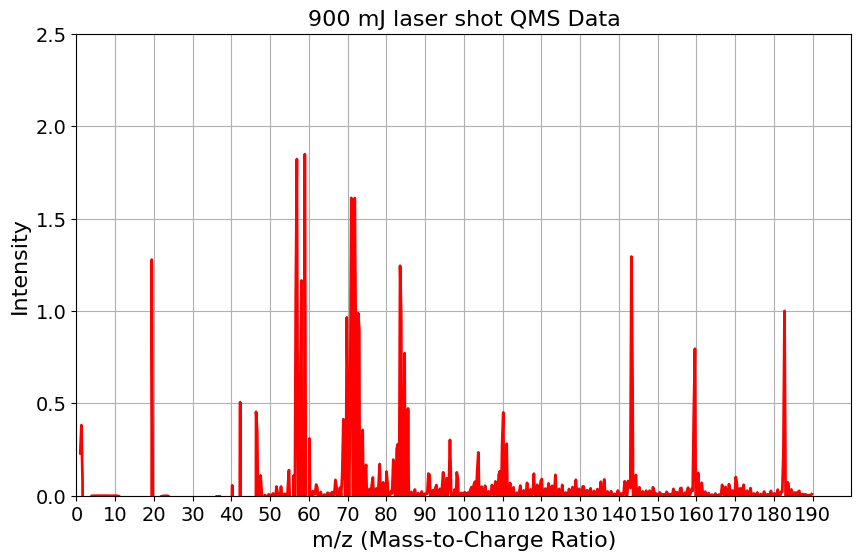

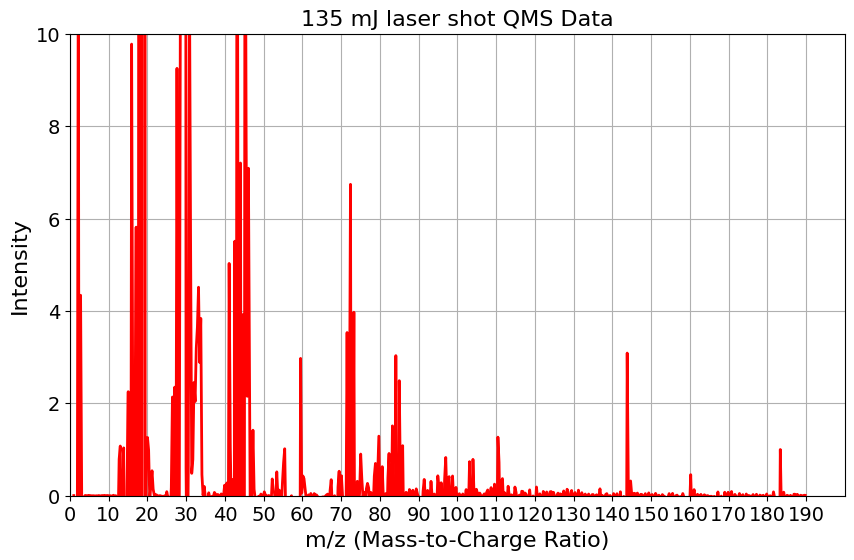

<Figure size 640x480 with 0 Axes>

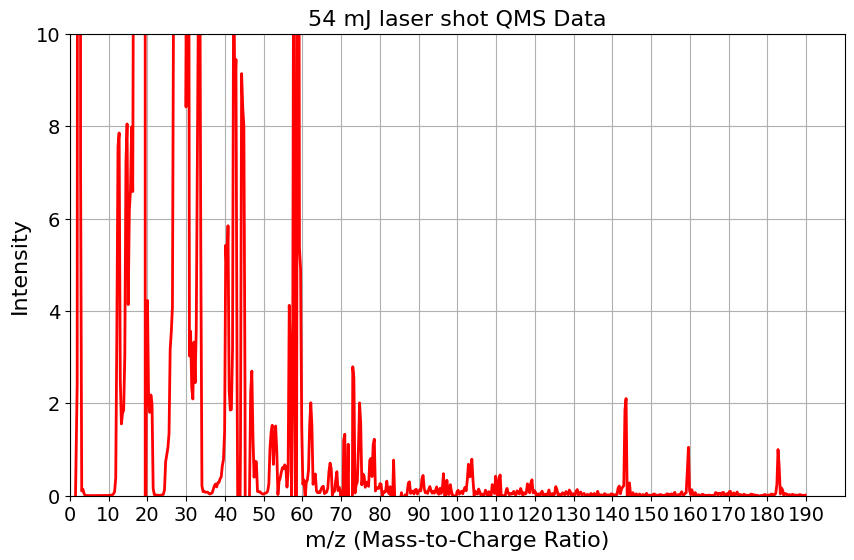

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.ndimage import gaussian_filter1d
from scipy.signal import butter, filtfilt

# CSVファイルを読み込む
# file_path = './250117/1_BG.CSV'  # 実際のCSVファイルパスに置き換えるのだ！
dir_name = './250117/'  # 実際のCSVファイルパスに置き換えるのだ！
# filename = ['1_BG','2_sig','3_BG','4_sig','5_BG','6_BG','7_sig','8_sig',
#             '9_sig','10_BG','11_sig','12_BG','13_BG','14_sig','15_sig']
filename = ['10_BG','11_sig','3_BG','4_sig','5_BG','6_BG','7_sig','8_sig',
            '9_sig','10_BG','11_sig','12_BG','13_BG','14_sig','15_sig']
# ##
# 1,2-> ex1: 1 laser shot 900 mJ
# 3,4-> ex2: a few laser shot 900 mJ same place
# 5,6,7 -> ex3: baking + a few laser shot 900 mJ at the same place
# 8,9 -> ex4: baking + a few laser 900 mJ same place
# 10,11 -> ex5: baking + a few laser 900 mJ 
# 12,13,14 -> ex6: baking + a few laser 135 mJ
# 14,15 -> ex7: baking + a few laser 54 mJ
# ##

downsampled_electric_current_data = []
downsampled_electric_current_nomalized_data = []
for j in np.arange(0,len(filename),1):
    file_path = dir_name + filename[j] + '.csv'
    # 18列を固定で読み込むように設定
    col_names = [f"col_{i}" for i in range(18)]  # 固定で18列の名前を作成
    data = pd.read_csv(
        file_path,
        header=None,
        encoding='cp932',
        sep=',',
        names=col_names,  # 18列分の名前を指定
        skip_blank_lines=False  # 空行をスキップしない
    )
    
    # データフレーム全体を確認
    # print(data.head(8))  
    # 測定範囲を抽出
    start_mz = int(data.iloc[5, 0])  # A6の値
    end_mz = int(data.iloc[5, 1])  # B6の値
    
    # 電流値を二次元配列に格納
    electric_current_values = []
    current_time_data = []
    
    # 8行目以降をループして各時刻のデータを取得
    i = 8
    while i < len(data):
        # 時刻の行をスキップ（列数が1になっている行を判定）
        if data.iloc[i].count() == 1:
            i += 1
            electric_current_values.append(current_time_data)
            current_time_data = []
            continue
    
        # データの範囲を取得
        current_block = data.iloc[i,0:17].values  # 18列分のデータを取得
        current_block = pd.to_numeric(current_block, errors='coerce')  # 数値に変換
        current_time_data = np.concatenate([current_time_data, current_block.flatten()])
    
        # 次のブロックへ
        i += 1
        
    # 最後のデータを追加
    if len(current_time_data) > 0:
        electric_current_values.append(current_time_data)
    
    
    # 測定範囲のm/z配列を作成
    mz_values = np.linspace(start_mz, end_mz, len(electric_current_values[0]))
    
    
    # 各時刻のデータを平均化
    electric_current_averages = np.mean(electric_current_values, axis=0)
    #ダウンサンプリング
    downsample_factor = 5  # 5点ごとに1点を取得
    # 移動平均フィルタで平滑化
    window_size = 5
    smoothed_electric_current_averages = np.convolve(electric_current_averages, np.ones(window_size)/window_size, mode='valid')
    downsampled_mz_values = mz_values[:len(smoothed_electric_current_averages)][::downsample_factor]
    downsampled_electric_current = smoothed_electric_current_averages[::downsample_factor]
    downsampled_electric_current_data.append(downsampled_electric_current)

    # 測定範囲のm/z配列を作成
    mz_values =np.arange(start_mz, end_mz, 1)
    # m/z = 28付近の窒素ピーク値を抽出
    mz_target = 58
    mz_tolerance = 3  # 許容範囲
    target_index = np.where((downsampled_mz_values >= mz_target - mz_tolerance) & (downsampled_mz_values <= mz_target + mz_tolerance))[0]
    nitrogen_peak_value = max(downsampled_electric_current[target_index])
    # print(f"Nitrogen peak value near m/z = {mz_target}: {nitrogen_peak_value}") 
    downsampled_electric_current_nomalized_data.append(downsampled_electric_current/nitrogen_peak_value)



mz_target = 181
mz_tolerance = 4  # 許容範囲
target_index = np.where((downsampled_mz_values >= mz_target - mz_tolerance) & (downsampled_mz_values <= mz_target + mz_tolerance))[0]

L_900mJ = downsampled_electric_current_nomalized_data[10] - downsampled_electric_current_nomalized_data[9]
tantal_peak_value = max(L_900mJ[target_index])
L_900mJ = L_900mJ/tantal_peak_value
L_135mJ = downsampled_electric_current_nomalized_data[13] - downsampled_electric_current_nomalized_data[12]
tantal_peak_value = max(L_135mJ[target_index])
L_135mJ = L_135mJ/tantal_peak_value
L_54mJ = downsampled_electric_current_nomalized_data[14] - downsampled_electric_current_nomalized_data[13]
tantal_peak_value = max(L_54mJ[target_index])
L_54mJ = L_54mJ/tantal_peak_value

# 平均値をプロット
plt.figure(figsize=(10, 6))
plt.plot(downsampled_mz_values, L_900mJ, label="900 mJ laser shot QMS Data", linewidth=2, color='red')
plt.ylim([0,2.5])
plt.xlim([0,200])
plt.xlabel("m/z (Mass-to-Charge Ratio)", fontsize=16)
plt.ylabel("Intensity", fontsize=16)
plt.xticks(np.arange(0, end_mz + 10, 10), fontsize=14)  # X軸を10刻みに設定
plt.yticks(fontsize=14)
plt.title("900 mJ laser shot QMS Data", fontsize=16)
plt.grid(True)
# plt.legend(fontsize=16)
# グラフを保存
output_path = './900mJ'
plt.savefig(output_path, dpi=300)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(downsampled_mz_values,L_135mJ, label="135 mJ laser shot QMS Data", linewidth=2, color='red')
plt.ylim([0,10])
plt.xlim([0,200])
plt.xlabel("m/z (Mass-to-Charge Ratio)", fontsize=16)
plt.ylabel("Intensity", fontsize=16)
plt.xticks(np.arange(0, end_mz + 10, 10), fontsize=14)  # X軸を10刻みに設定
plt.yticks(fontsize=14)
plt.title("135 mJ laser shot QMS Data", fontsize=16)
plt.grid(True)
# plt.legend(fontsize=16)
plt.show()
# グラフを保存
output_path = './135mJ'
plt.savefig(output_path, dpi=300)


plt.figure(figsize=(10, 6))
plt.plot(downsampled_mz_values, L_54mJ, label="54 mJ laser shot QMS Data", linewidth=2, color='red')
plt.ylim([0,10])
plt.xlim([0,200])
plt.xlabel("m/z (Mass-to-Charge Ratio)", fontsize=16)
plt.ylabel("Intensity", fontsize=16)
plt.xticks(np.arange(0, end_mz + 10, 10), fontsize=14)  # X軸を10刻みに設定
plt.yticks(fontsize=14)
plt.title("54 mJ laser shot QMS Data", fontsize=16)
plt.grid(True)
# plt.legend(fontsize=16)
# グラフを保存
output_path = './54mJ'
plt.savefig(output_path, dpi=300)


array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

Nitrogen peak value near m/z = 28: 2.896666666666667e-11


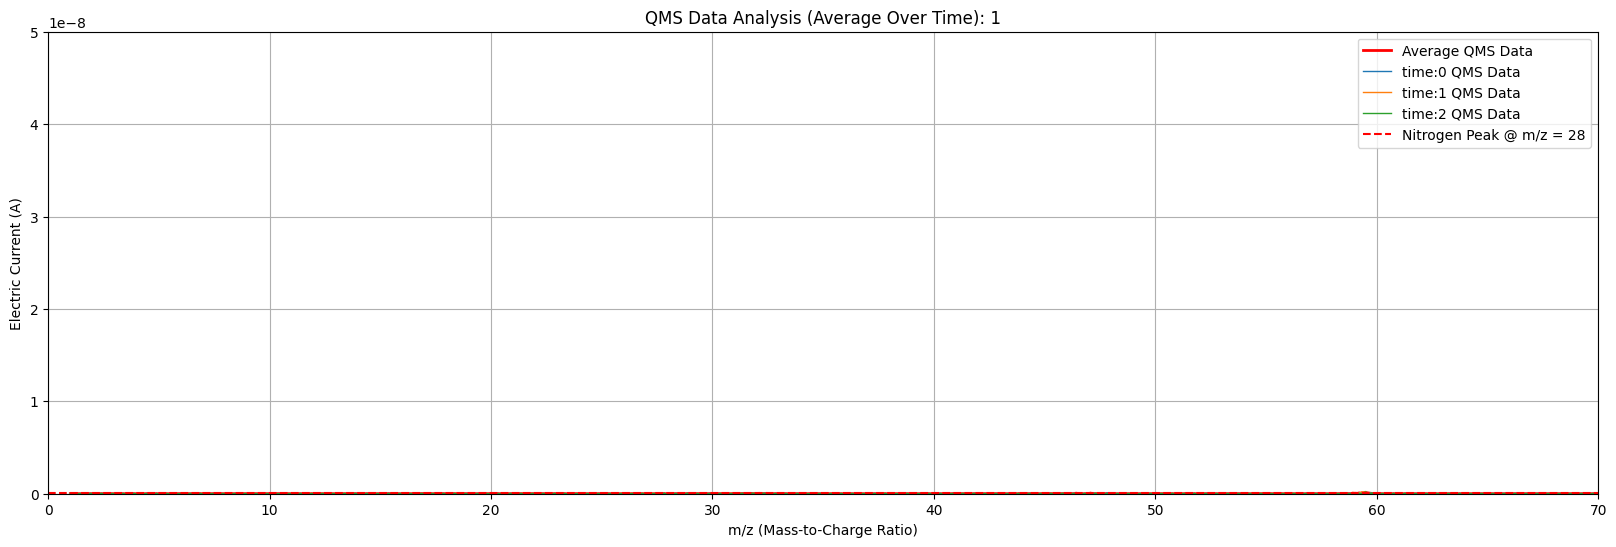

Nitrogen peak value near m/z = 28: 3.158e-08


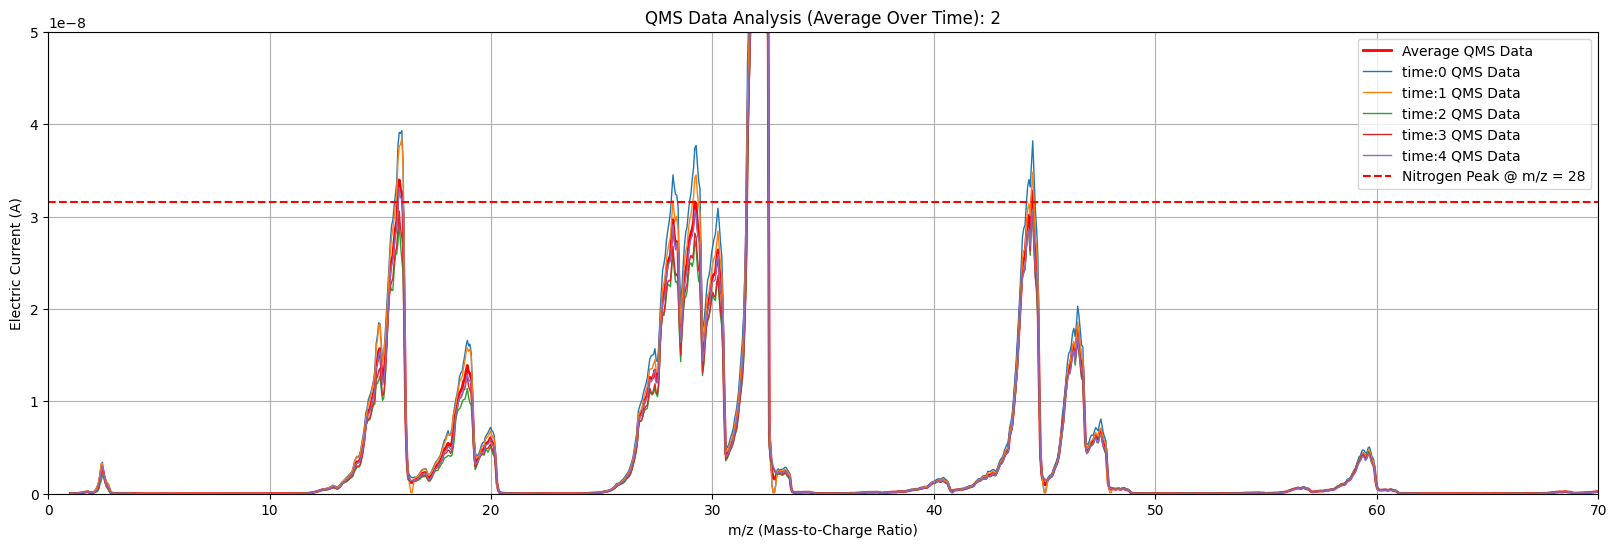

Nitrogen peak value near m/z = 28: 4.136666666666667e-07


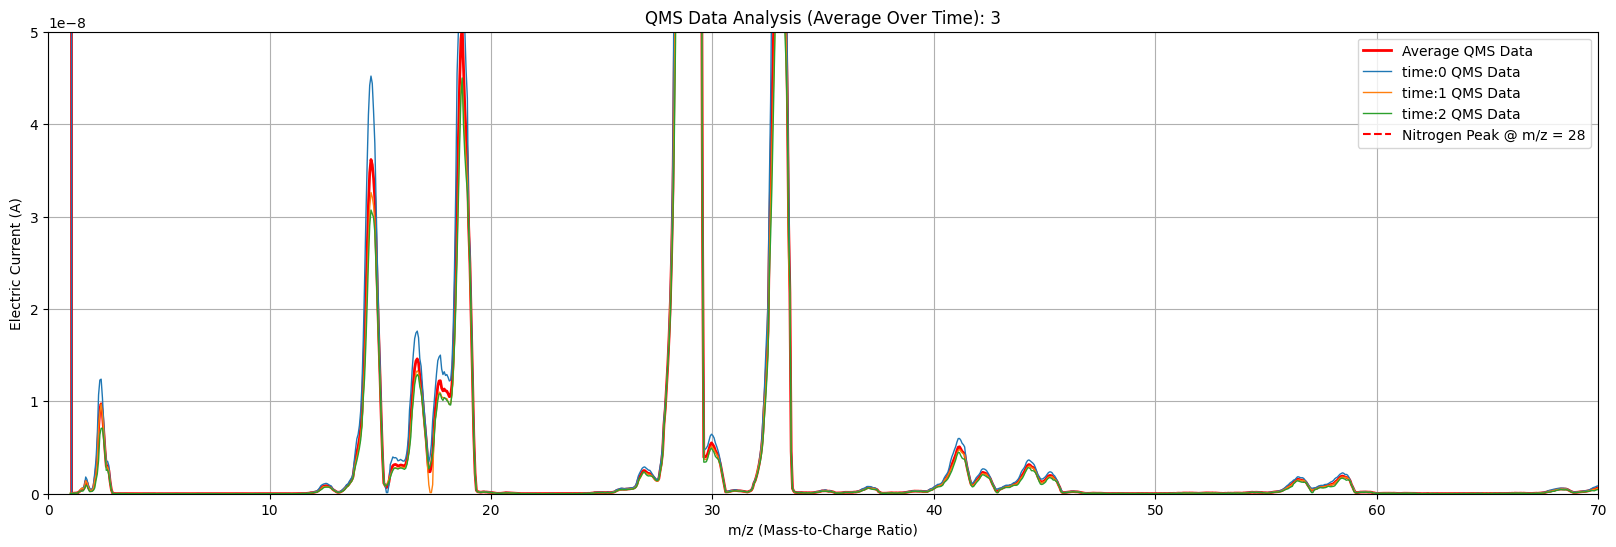

Nitrogen peak value near m/z = 28: 3.866666666666667e-11


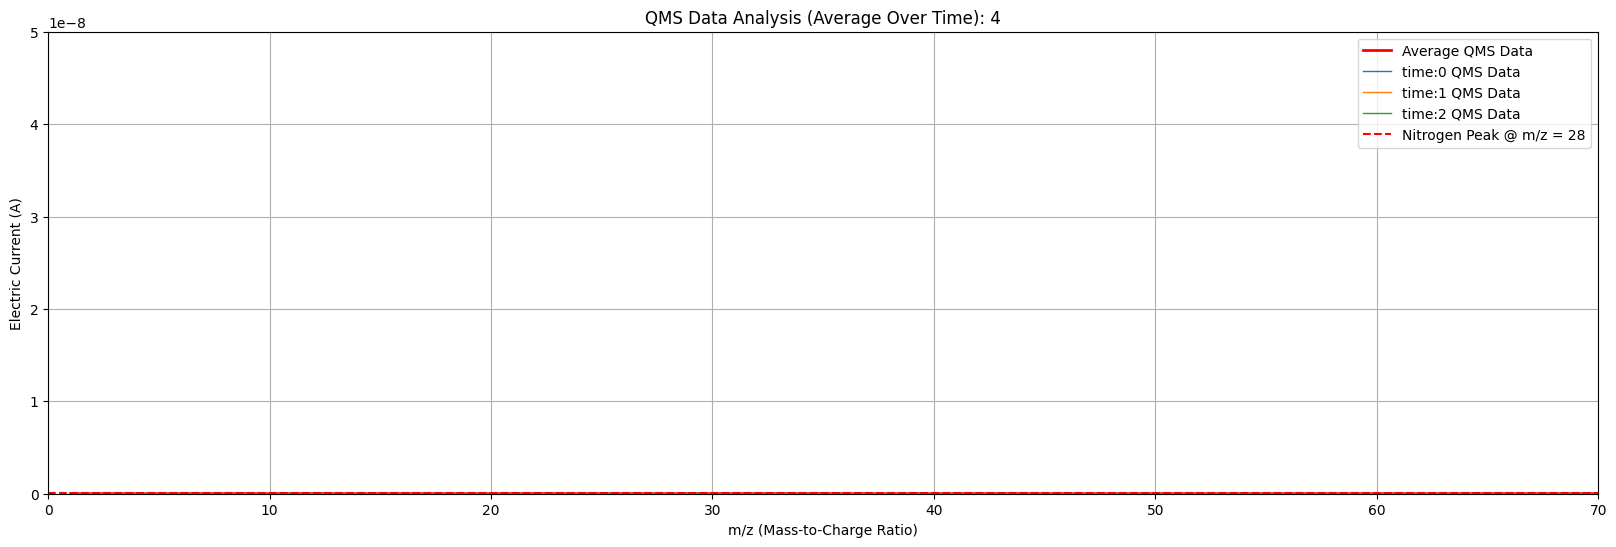

Nitrogen peak value near m/z = 28: 9.498e-12


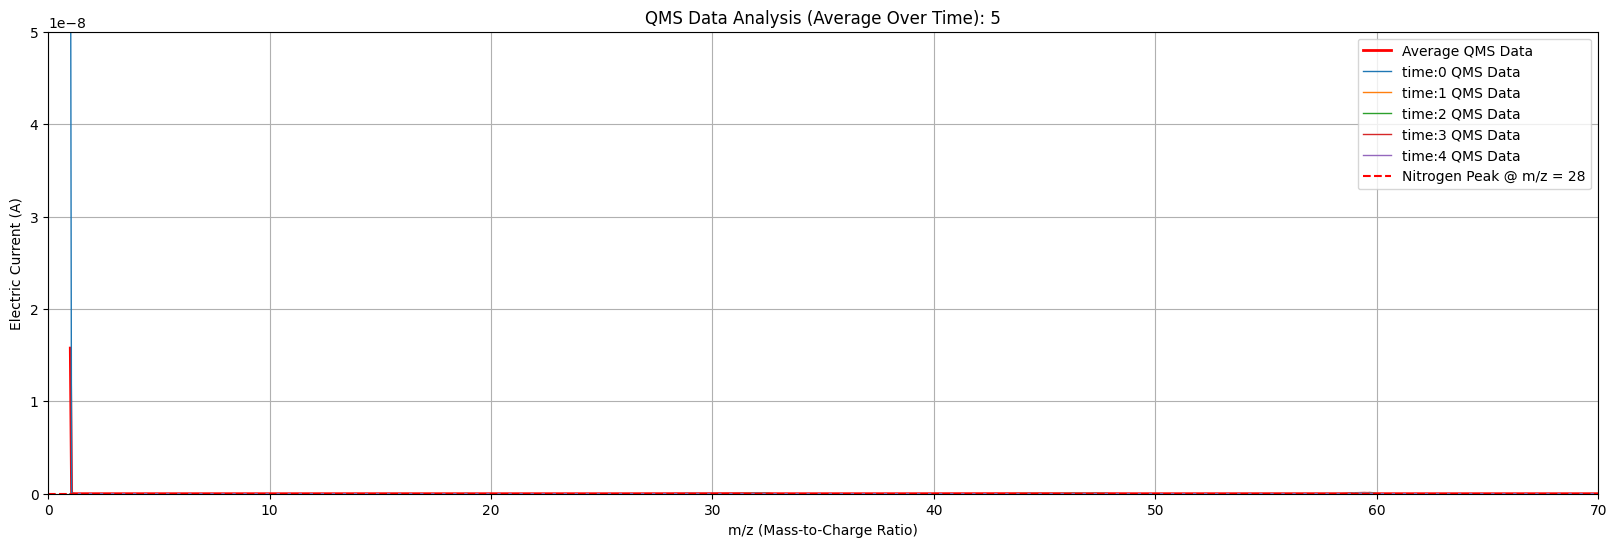

Nitrogen peak value near m/z = 28: 2.9679999999999995e-08


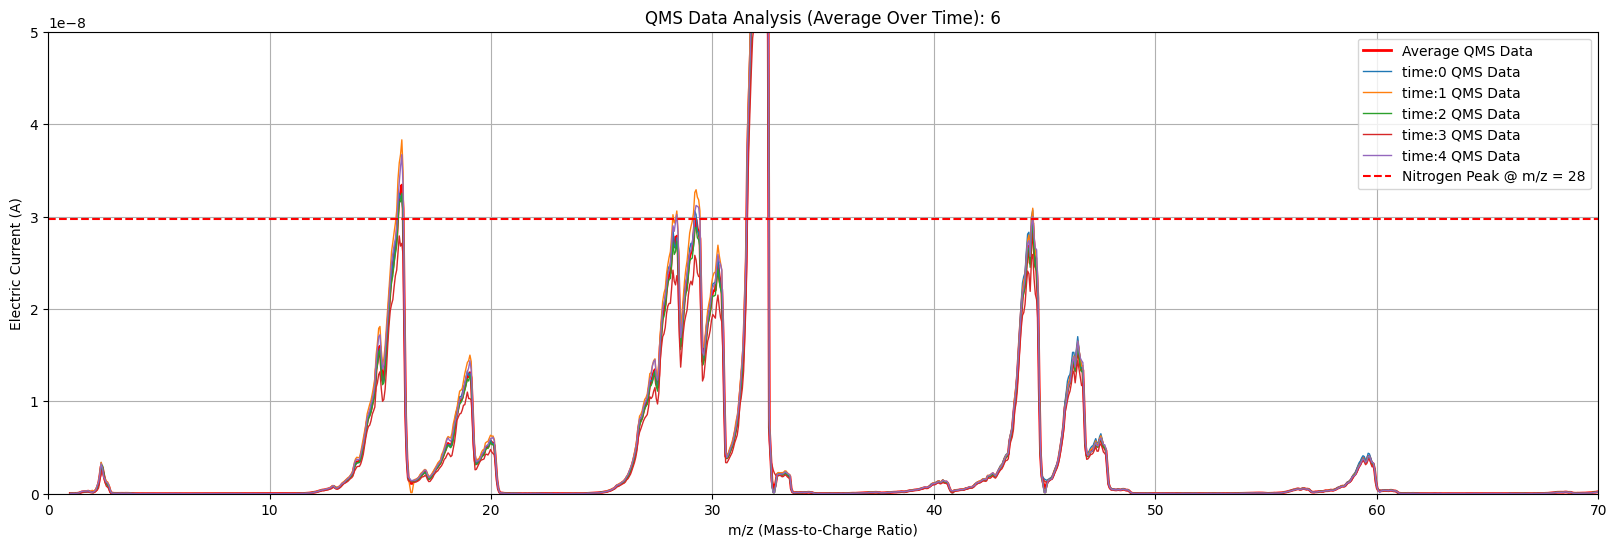

In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# CSVファイルを読み込む
# file_path = './250117/1_BG.CSV'  # 実際のCSVファイルパスに置き換えるのだ！
dir_name = './250129/'  # 実際のCSVファイルパスに置き換えるのだ！
filename = ['1','2','3','4','5','6']

for j in np.arange(0,len(filename),1):
    file_path = dir_name + filename[j] + '.csv'
    # 18列を固定で読み込むように設定
    col_names = [f"col_{i}" for i in range(18)]  # 固定で18列の名前を作成
    data = pd.read_csv(
        file_path,
        header=None,
        encoding='cp932',
        sep=',',
        names=col_names,  # 18列分の名前を指定
        skip_blank_lines=False  # 空行をスキップしない
    )
    
    # データフレーム全体を確認
    # print(data.head(8))  
    # 測定範囲を抽出
    start_mz = int(data.iloc[5, 0])  # A6の値
    end_mz = int(data.iloc[5, 1])  # B6の値
    
    # 電流値を二次元配列に格納
    electric_current_values = []
    current_time_data = []
    
    # 8行目以降をループして各時刻のデータを取得
    i = 8
    while i < len(data):
        # 時刻の行をスキップ（列数が1になっている行を判定）
        if data.iloc[i].count() == 1:
            i += 1
            electric_current_values.append(current_time_data)
            current_time_data = []
            continue
    
        # データの範囲を取得
        current_block = data.iloc[i,0:17].values  # 18列分のデータを取得
        current_block = pd.to_numeric(current_block, errors='coerce')  # 数値に変換
        current_time_data = np.concatenate([current_time_data, current_block.flatten()])
    
        # 次のブロックへ
        i += 1
    
    
    # 最後のデータを追加
    if len(current_time_data) > 0:
        electric_current_values.append(current_time_data)
    
    # 各時刻のデータを平均化
    electric_current_averages = np.mean(electric_current_values, axis=0)

    # 測定範囲のm/z配列を作成
    mz_values = np.linspace(start_mz, end_mz, len(electric_current_values[0]))
    # m/z = 28付近の窒素ピーク値を抽出
    mz_target = 28
    mz_tolerance = 2  # 許容範囲
    target_index = np.where((mz_values >= mz_target - mz_tolerance) & (mz_values <= mz_target + mz_tolerance))[0]
    nitrogen_peak_value = max(electric_current_averages[target_index])
    print(f"Nitrogen peak value near m/z = {mz_target}: {nitrogen_peak_value}")
    
    # 平均値をプロット
    plt.figure(figsize=(20, 6))
    plt.plot(mz_values, electric_current_averages, label="Average QMS Data", linewidth=2, color='red')
    for i in np.arange(0,len(electric_current_values),1):
        plt.plot(mz_values, electric_current_values[i], linewidth=1, label="time:{} QMS Data".format(i))
    
    plt.axhline(y=nitrogen_peak_value, color='r', linestyle='--', label=f"Nitrogen Peak @ m/z = {mz_target}")

    plt.ylim([0,5e-8])
    plt.xlim([0,70])
    plt.xlabel("m/z (Mass-to-Charge Ratio)")
    plt.ylabel("Electric Current (A)")
    plt.title("QMS Data Analysis (Average Over Time): {}".format(filename[j]))
    plt.xticks(np.arange(0, end_mz+10, 10))  # X軸を10刻みに設定
    plt.grid(True)
    plt.legend()
    plt.show()
    
    # # グラフを保存
    # output_filename = filename[j] + '_average_plot.png'
    # output_path = os.path.join('./', output_filename)
    # plt.savefig(output_path, dpi=300)
    # plt.show()


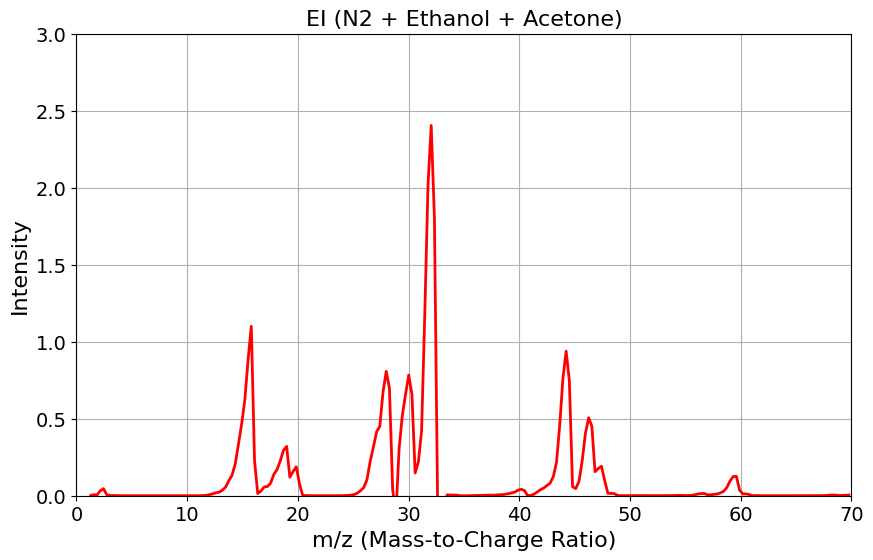

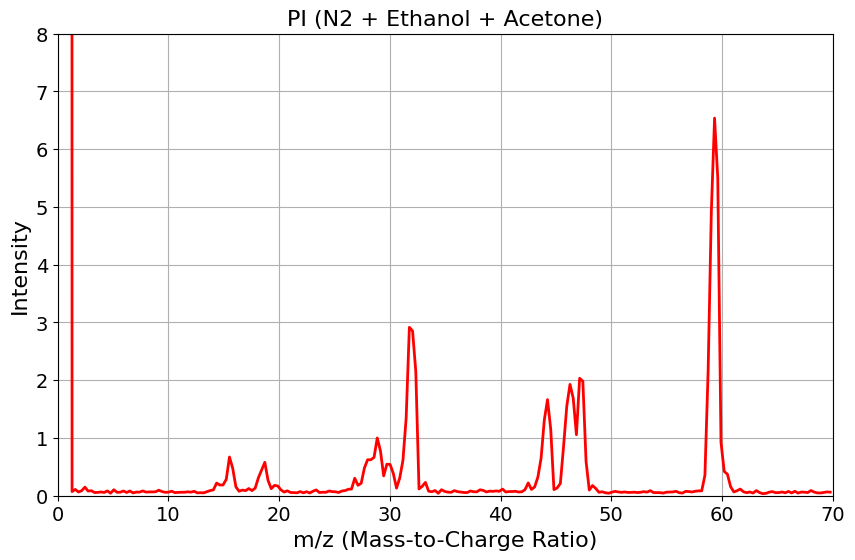

<Figure size 640x480 with 0 Axes>

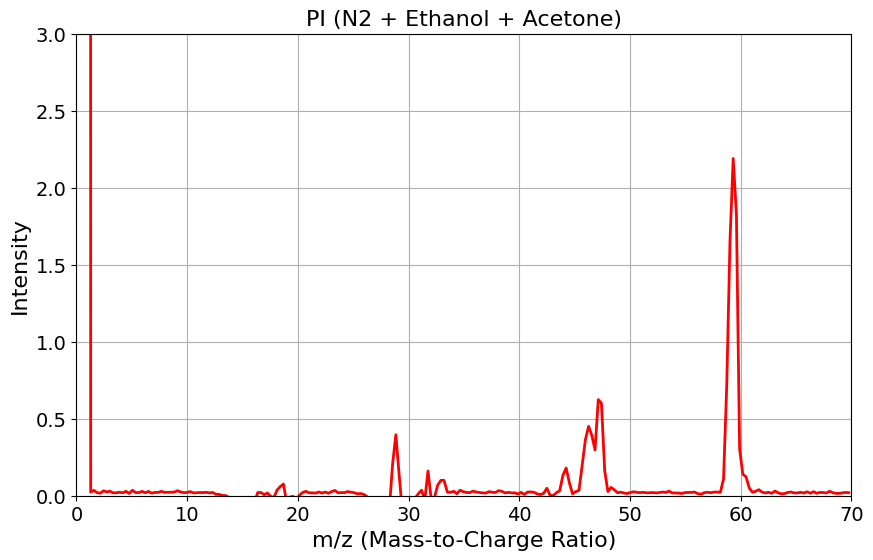

<Figure size 640x480 with 0 Axes>

In [156]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.ndimage import gaussian_filter1d
from scipy.signal import butter, filtfilt

# CSVファイルを読み込む
# file_path = './250117/1_BG.CSV'  # 実際のCSVファイルパスに置き換えるのだ！
dir_name = './250129/'  # 実際のCSVファイルパスに置き換えるのだ！
filename = ['1','2','3','4','5','6']
# ##
# 1,2-> ex1: 1 laser shot 900 mJ
# 3,4-> ex2: a few laser shot 900 mJ same place
# 5,6,7 -> ex3: baking + a few laser shot 900 mJ at the same place
# 8,9 -> ex4: baking + a few laser 900 mJ same place
# 10,11 -> ex5: baking + a few laser 900 mJ 
# 12,13,14 -> ex6: baking + a few laser 135 mJ
# 14,15 -> ex7: baking + a few laser 54 mJ
# ##

downsampled_electric_current_data = []
downsampled_electric_current_nomalized_data = []
for j in np.arange(0,len(filename),1):
    file_path = dir_name + filename[j] + '.csv'
    # 18列を固定で読み込むように設定
    col_names = [f"col_{i}" for i in range(18)]  # 固定で18列の名前を作成
    data = pd.read_csv(
        file_path,
        header=None,
        encoding='cp932',
        sep=',',
        names=col_names,  # 18列分の名前を指定
        skip_blank_lines=False  # 空行をスキップしない
    )
    
    # データフレーム全体を確認
    # print(data.head(8))  
    # 測定範囲を抽出
    start_mz = int(data.iloc[5, 0])  # A6の値
    end_mz = int(data.iloc[5, 1])  # B6の値
    
    # 電流値を二次元配列に格納
    electric_current_values = []
    current_time_data = []
    
    # 8行目以降をループして各時刻のデータを取得
    i = 8
    while i < len(data):
        # 時刻の行をスキップ（列数が1になっている行を判定）
        if data.iloc[i].count() == 1:
            i += 1
            electric_current_values.append(current_time_data)
            current_time_data = []
            continue
    
        # データの範囲を取得
        current_block = data.iloc[i,0:17].values  # 18列分のデータを取得
        current_block = pd.to_numeric(current_block, errors='coerce')  # 数値に変換
        current_time_data = np.concatenate([current_time_data, current_block.flatten()])
    
        # 次のブロックへ
        i += 1
    
    
    # 最後のデータを追加
    if len(current_time_data) > 0:
        electric_current_values.append(current_time_data)
    
    
    # 測定範囲のm/z配列を作成
    mz_values = np.linspace(start_mz, end_mz, len(electric_current_values[0]))
    
    
    # 各時刻のデータを平均化
    electric_current_averages = np.mean(electric_current_values, axis=0)
    #ダウンサンプリング
    downsample_factor = 5  # 5点ごとに1点を取得
    # 移動平均フィルタで平滑化
    window_size = 5
    smoothed_electric_current_averages = np.convolve(electric_current_averages, np.ones(window_size)/window_size, mode='valid')
    downsampled_mz_values = mz_values[:len(smoothed_electric_current_averages)][::downsample_factor]
    downsampled_electric_current = smoothed_electric_current_averages[::downsample_factor]
    downsampled_electric_current_data.append(downsampled_electric_current)

    # 測定範囲のm/z配列を作成
    mz_values = np.linspace(start_mz, end_mz, len(electric_current_values[0]))
    # m/z = 28付近の窒素ピーク値を抽出
    mz_target = 28
    mz_tolerance = 3  # 許容範囲
    target_index = np.where((downsampled_mz_values >= mz_target - mz_tolerance) & (downsampled_mz_values <= mz_target + mz_tolerance))[0]
    nitrogen_peak_value = max(downsampled_electric_current[target_index])
    # print(f"Nitrogen peak value near m/z = {mz_target}: {nitrogen_peak_value}") 
    downsampled_electric_current_nomalized_data.append(downsampled_electric_current/nitrogen_peak_value)

    

mz_target = 181
mz_tolerance = 4  # 許容範囲
target_index = np.where((downsampled_mz_values >= mz_target - mz_tolerance) & (downsampled_mz_values <= mz_target + mz_tolerance))[0]

PI = downsampled_electric_current_nomalized_data[4]
EI = downsampled_electric_current_nomalized_data[5] - downsampled_electric_current_nomalized_data[2]

mz_target = 31
mz_tolerance = 3  # 許容範囲
target_index = np.where((downsampled_mz_values >= mz_target - mz_tolerance) & (downsampled_mz_values <= mz_target + mz_tolerance))[0]
nitrogen_peak_value_PI = max(PI[target_index])
nitrogen_peak_value_EI = max(EI[target_index])
PI_ideal = PI/nitrogen_peak_value_PI - EI/nitrogen_peak_value_EI

# 平均値をプロット
plt.figure(figsize=(10, 6))
plt.plot(downsampled_mz_values, EI, label="900 mJ laser shot QMS Data", linewidth=2, color='red')
plt.ylim([0,3])
plt.xlim([0,70])
plt.xlabel("m/z (Mass-to-Charge Ratio)", fontsize=16)
plt.ylabel("Intensity", fontsize=16)
plt.xticks(np.arange(0, end_mz + 10, 10), fontsize=14)  # X軸を10刻みに設定
plt.yticks(fontsize=14)
plt.title("EI (N2 + Ethanol + Acetone)", fontsize=16)
plt.grid(True)
# plt.legend(fontsize=16)
# グラフを保存
output_path = './900mJ'
plt.savefig(output_path, dpi=300)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(downsampled_mz_values,PI, label="135 mJ laser shot QMS Data", linewidth=2, color='red')
plt.ylim([0,8])
plt.xlim([0,70])
plt.xlabel("m/z (Mass-to-Charge Ratio)", fontsize=16)
plt.ylabel("Intensity", fontsize=16)
plt.xticks(np.arange(0, end_mz + 10, 10), fontsize=14)  # X軸を10刻みに設定
plt.yticks(fontsize=14)
plt.title("PI (N2 + Ethanol + Acetone)", fontsize=16)
plt.grid(True)
# plt.legend(fontsize=16)
plt.show()
# グラフを保存
output_path = './135mJ'
plt.savefig(output_path, dpi=300)

plt.figure(figsize=(10, 6))
plt.plot(downsampled_mz_values,PI_ideal, label="135 mJ laser shot QMS Data", linewidth=2, color='red')
plt.ylim([0,3])
plt.xlim([0,70])
plt.xlabel("m/z (Mass-to-Charge Ratio)", fontsize=16)
plt.ylabel("Intensity", fontsize=16)
plt.xticks(np.arange(0, end_mz + 10, 10), fontsize=14)  # X軸を10刻みに設定
plt.yticks(fontsize=14)
plt.title("PI (N2 + Ethanol + Acetone)", fontsize=16)
plt.grid(True)
# plt.legend(fontsize=16)
plt.show()
# グラフを保存
output_path = './135mJ'
plt.savefig(output_path, dpi=300)


Nitrogen peak value near m/z = 28: 3.99e-06


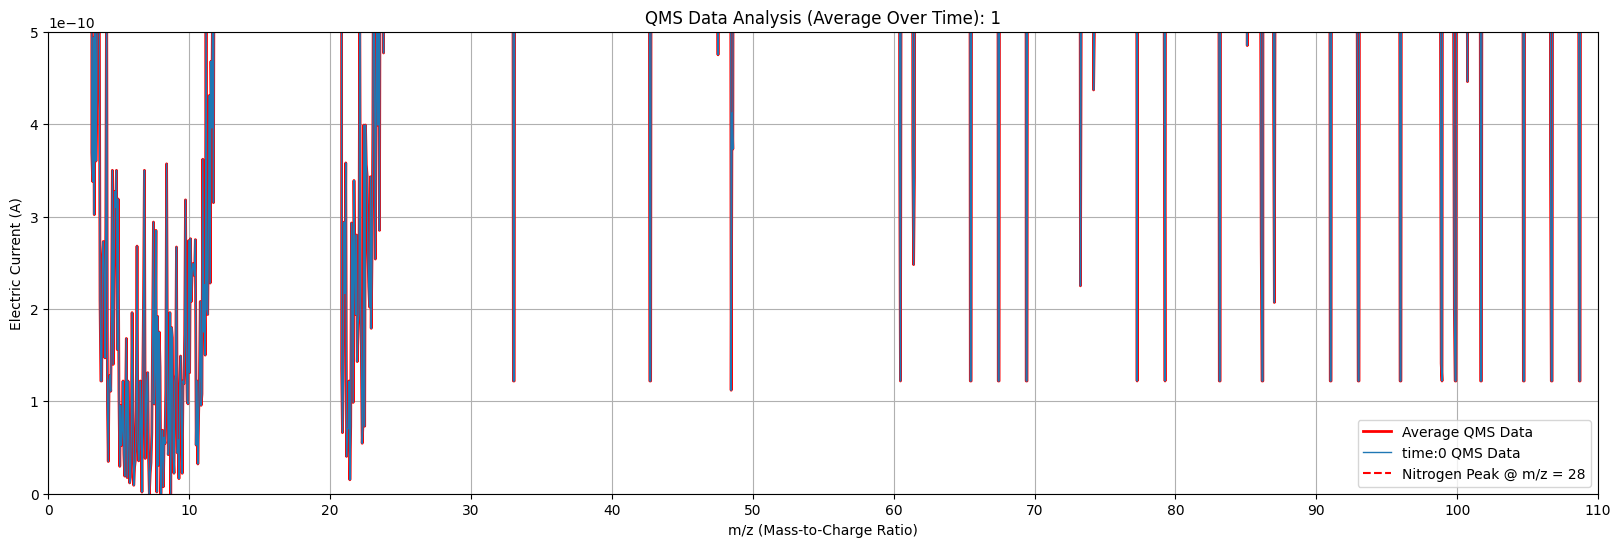

Nitrogen peak value near m/z = 28: 5.13e-11


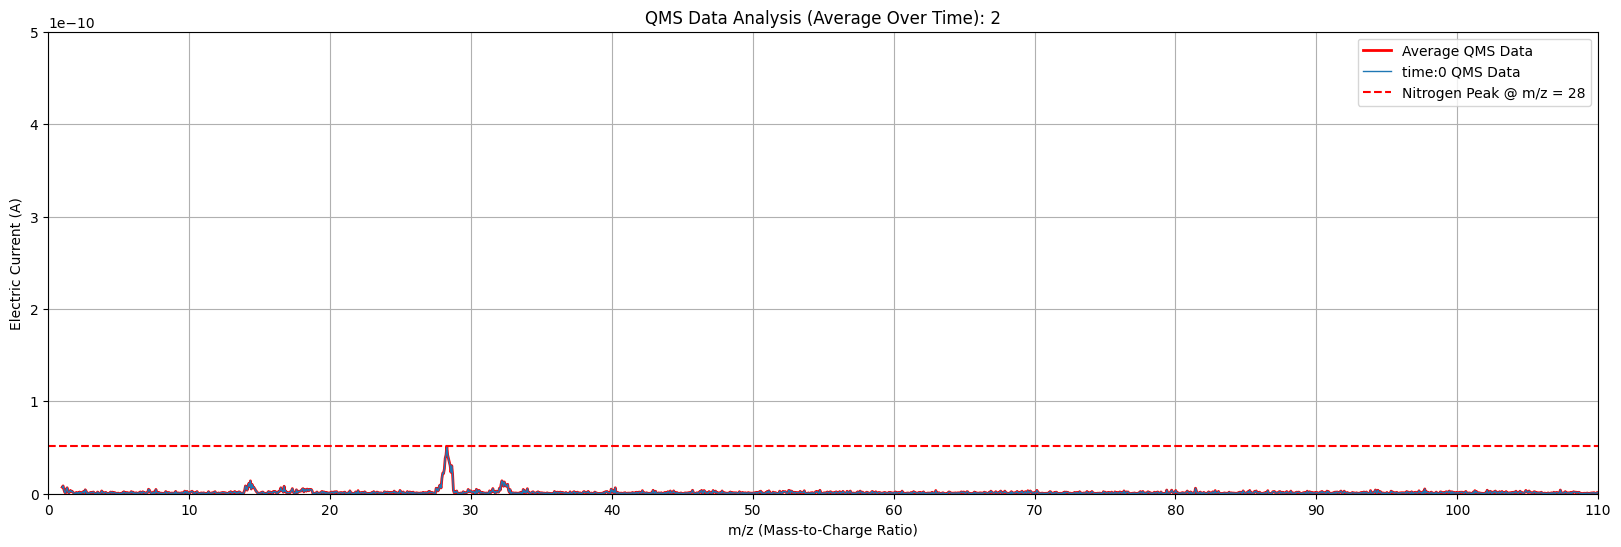

Nitrogen peak value near m/z = 28: 9.49e-07


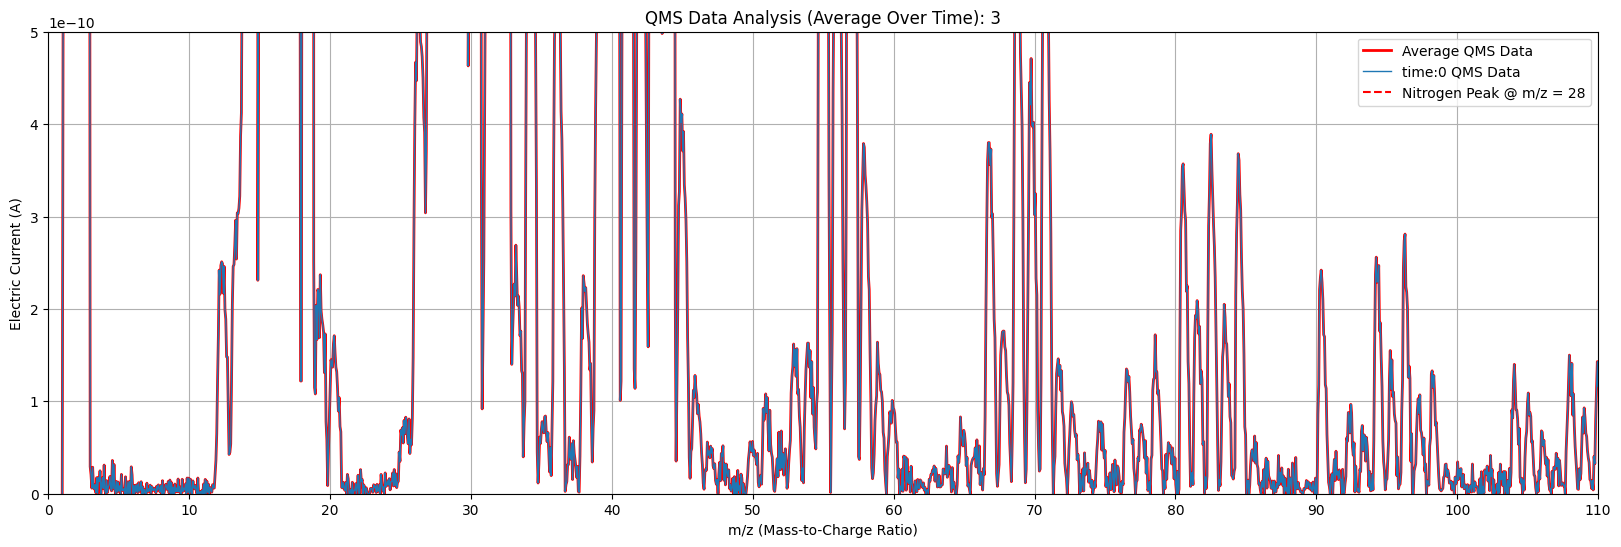

Nitrogen peak value near m/z = 28: 3.22e-11


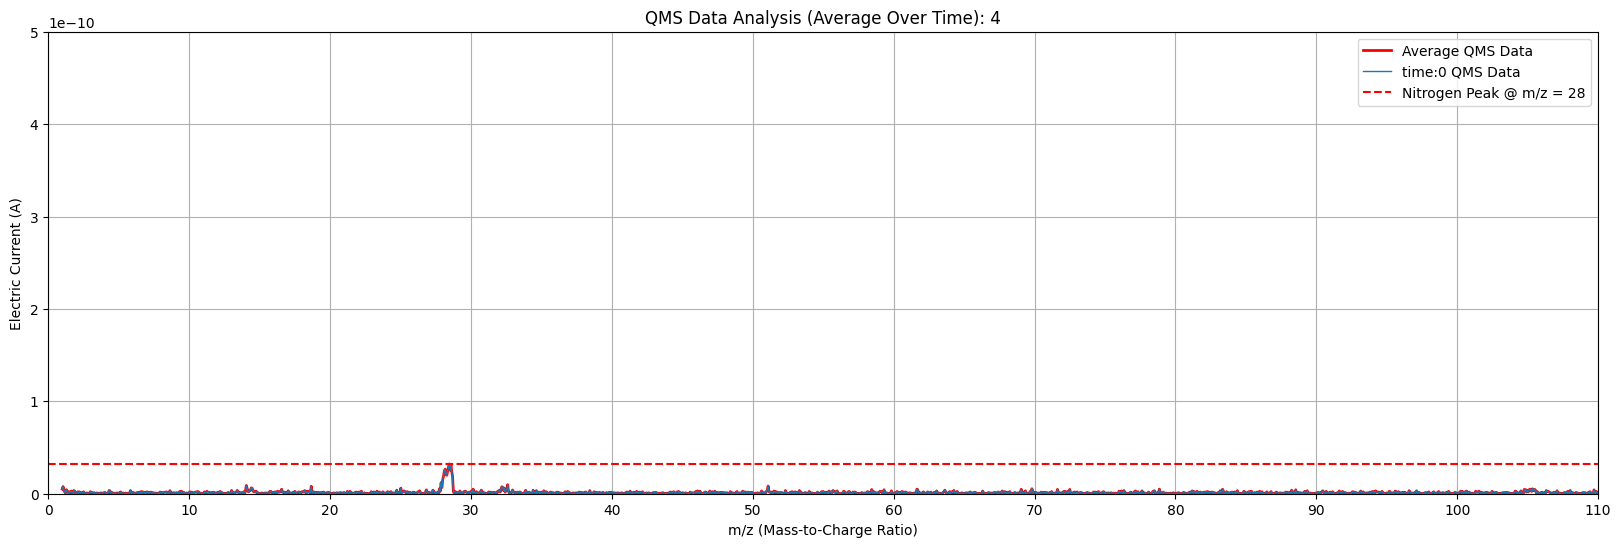

Nitrogen peak value near m/z = 28: 1.5e-10


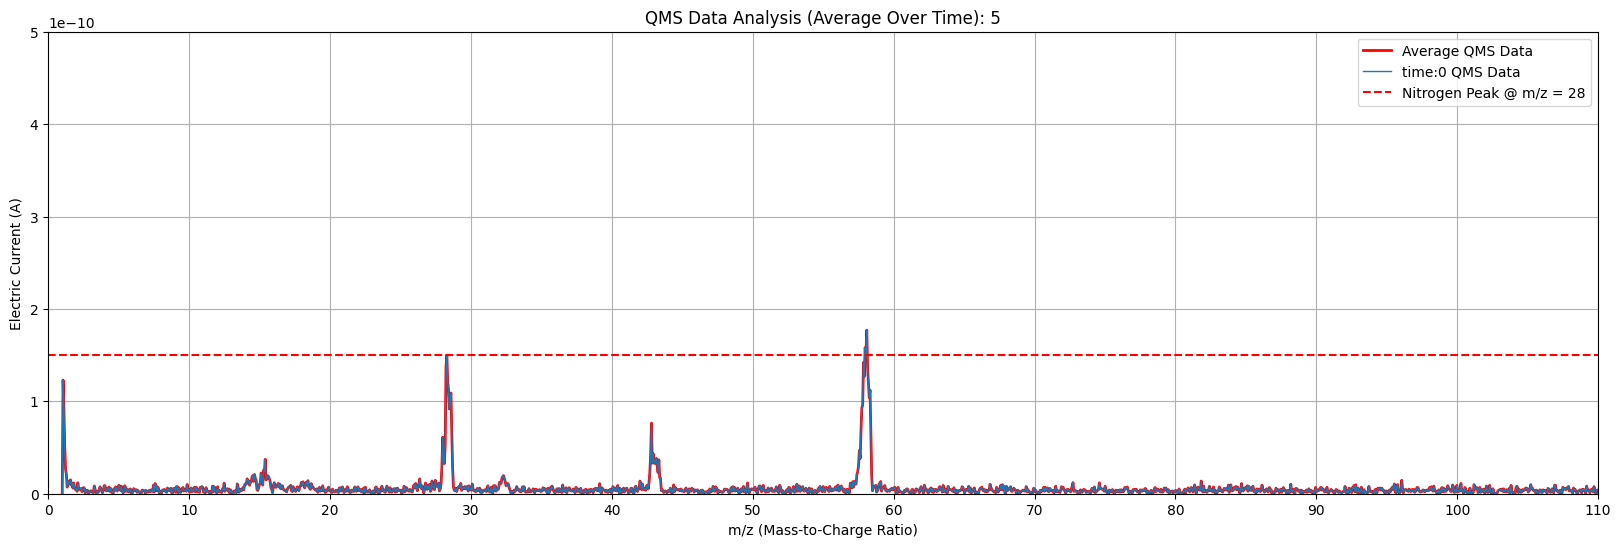

In [142]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# CSVファイルを読み込む
# file_path = './250117/1_BG.CSV'  # 実際のCSVファイルパスに置き換えるのだ！
dir_name = './241230/'  # 実際のCSVファイルパスに置き換えるのだ！
filename = ['1','2','3','4','5']

for j in np.arange(0,len(filename),1):
    file_path = dir_name + filename[j] + '.csv'
    # 18列を固定で読み込むように設定
    col_names = [f"col_{i}" for i in range(18)]  # 固定で18列の名前を作成
    data = pd.read_csv(
        file_path,
        header=None,
        encoding='cp932',
        sep=',',
        names=col_names,  # 18列分の名前を指定
        skip_blank_lines=False  # 空行をスキップしない
    )
    
    # データフレーム全体を確認
    # print(data.head(8))  
    # 測定範囲を抽出
    start_mz = int(data.iloc[5, 0])  # A6の値
    end_mz = int(data.iloc[5, 1])  # B6の値
    
    # 電流値を二次元配列に格納
    electric_current_values = []
    current_time_data = []
    
    # 8行目以降をループして各時刻のデータを取得
    i = 8
    while i < len(data):
        # 時刻の行をスキップ（列数が1になっている行を判定）
        if data.iloc[i].count() == 1:
            i += 1
            electric_current_values.append(current_time_data)
            current_time_data = []
            continue
    
        # データの範囲を取得
        current_block = data.iloc[i,0:17].values  # 18列分のデータを取得
        current_block = pd.to_numeric(current_block, errors='coerce')  # 数値に変換
        current_time_data = np.concatenate([current_time_data, current_block.flatten()])
    
        # 次のブロックへ
        i += 1
    
    
    # 最後のデータを追加
    if len(current_time_data) > 0:
        electric_current_values.append(current_time_data)
    
    # 各時刻のデータを平均化
    electric_current_averages = np.mean(electric_current_values, axis=0)

    # 測定範囲のm/z配列を作成
    mz_values = np.linspace(start_mz, end_mz, len(electric_current_values[0]))
    # m/z = 28付近の窒素ピーク値を抽出
    mz_target = 28
    mz_tolerance = 2  # 許容範囲
    target_index = np.where((mz_values >= mz_target - mz_tolerance) & (mz_values <= mz_target + mz_tolerance))[0]
    nitrogen_peak_value = max(electric_current_averages[target_index])
    print(f"Nitrogen peak value near m/z = {mz_target}: {nitrogen_peak_value}")
    
    # 平均値をプロット
    plt.figure(figsize=(20, 6))
    plt.plot(mz_values, electric_current_averages, label="Average QMS Data", linewidth=2, color='red')
    for i in np.arange(0,len(electric_current_values),1):
        plt.plot(mz_values, electric_current_values[i], linewidth=1, label="time:{} QMS Data".format(i))
    
    plt.axhline(y=nitrogen_peak_value, color='r', linestyle='--', label=f"Nitrogen Peak @ m/z = {mz_target}")

    plt.ylim([0,5e-10])
    plt.xlim([0,70])
    plt.xlabel("m/z (Mass-to-Charge Ratio)")
    plt.ylabel("Electric Current (A)")
    plt.title("QMS Data Analysis (Average Over Time): {}".format(filename[j]))
    plt.xticks(np.arange(0, end_mz+10, 10))  # X軸を10刻みに設定
    plt.grid(True)
    plt.legend()
    plt.show()
    
    # # グラフを保存
    # output_filename = filename[j] + '_average_plot.png'
    # output_path = os.path.join('./', output_filename)
    # plt.savefig(output_path, dpi=300)
    # plt.show()


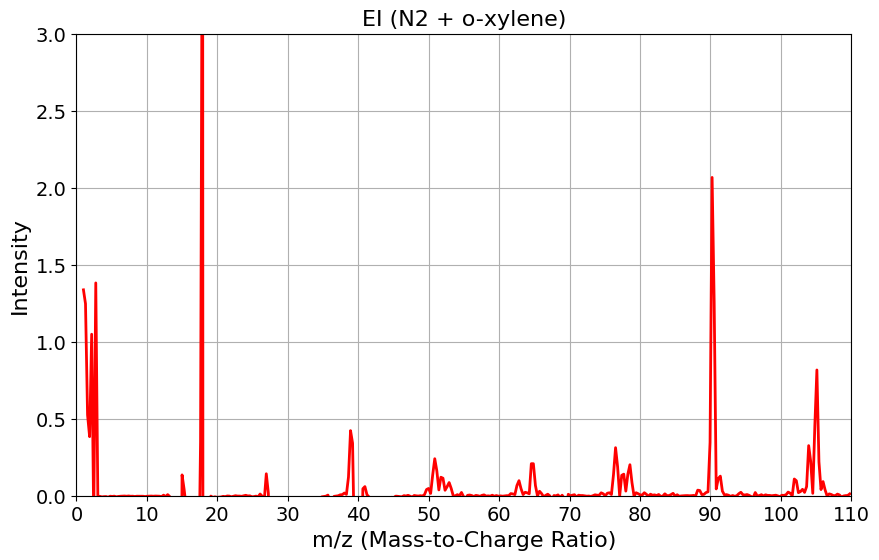

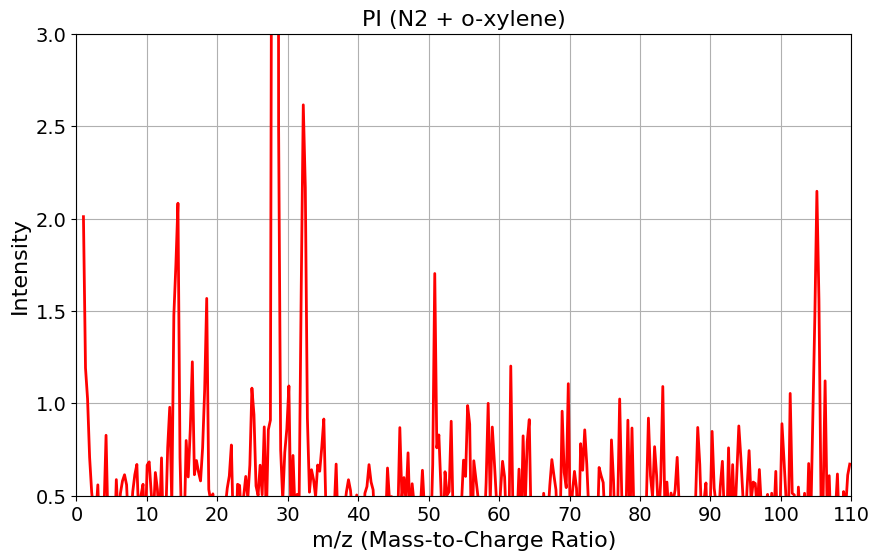

<Figure size 640x480 with 0 Axes>

In [151]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.ndimage import gaussian_filter1d
from scipy.signal import butter, filtfilt

# CSVファイルを読み込む
# file_path = './250117/1_BG.CSV'  # 実際のCSVファイルパスに置き換えるのだ！
dir_name = './241230/'  # 実際のCSVファイルパスに置き換えるのだ！
filename = ['1','2','3','4','5']
# ##
# 1,2-> ex1: 1 laser shot 900 mJ
# 3,4-> ex2: a few laser shot 900 mJ same place
# 5,6,7 -> ex3: baking + a few laser shot 900 mJ at the same place
# 8,9 -> ex4: baking + a few laser 900 mJ same place
# 10,11 -> ex5: baking + a few laser 900 mJ 
# 12,13,14 -> ex6: baking + a few laser 135 mJ
# 14,15 -> ex7: baking + a few laser 54 mJ
# ##

downsampled_electric_current_data = []
downsampled_electric_current_nomalized_data = []
for j in np.arange(0,len(filename),1):
    file_path = dir_name + filename[j] + '.csv'
    # 18列を固定で読み込むように設定
    col_names = [f"col_{i}" for i in range(18)]  # 固定で18列の名前を作成
    data = pd.read_csv(
        file_path,
        header=None,
        encoding='cp932',
        sep=',',
        names=col_names,  # 18列分の名前を指定
        skip_blank_lines=False  # 空行をスキップしない
    )
    
    # データフレーム全体を確認
    # print(data.head(8))  
    # 測定範囲を抽出
    start_mz = int(data.iloc[5, 0])  # A6の値
    end_mz = int(data.iloc[5, 1])  # B6の値
    
    # 電流値を二次元配列に格納
    electric_current_values = []
    current_time_data = []
    
    # 8行目以降をループして各時刻のデータを取得
    i = 8
    while i < len(data):
        # 時刻の行をスキップ（列数が1になっている行を判定）
        if data.iloc[i].count() == 1:
            i += 1
            electric_current_values.append(current_time_data)
            current_time_data = []
            continue
    
        # データの範囲を取得
        current_block = data.iloc[i,0:17].values  # 18列分のデータを取得
        current_block = pd.to_numeric(current_block, errors='coerce')  # 数値に変換
        current_time_data = np.concatenate([current_time_data, current_block.flatten()])
    
        # 次のブロックへ
        i += 1
    
    
    # 最後のデータを追加
    if len(current_time_data) > 0:
        electric_current_values.append(current_time_data)
    
    
    # 測定範囲のm/z配列を作成
    mz_values = np.linspace(start_mz, end_mz, len(electric_current_values[0]))
    
    
    # 各時刻のデータを平均化
    electric_current_averages = np.mean(electric_current_values, axis=0)
    #ダウンサンプリング
    downsample_factor = 5  # 5点ごとに1点を取得
    # 移動平均フィルタで平滑化
    window_size = 5
    smoothed_electric_current_averages = np.convolve(electric_current_averages, np.ones(window_size)/window_size, mode='valid')
    downsampled_mz_values = mz_values[:len(smoothed_electric_current_averages)][::downsample_factor]
    downsampled_electric_current = smoothed_electric_current_averages[::downsample_factor]
    downsampled_electric_current_data.append(downsampled_electric_current)

    # 測定範囲のm/z配列を作成
    mz_values = np.linspace(start_mz, end_mz, len(electric_current_values[0]))
    # m/z = 28付近の窒素ピーク値を抽出
    mz_target = 58
    mz_tolerance = 3  # 許容範囲
    target_index = np.where((downsampled_mz_values >= mz_target - mz_tolerance) & (downsampled_mz_values <= mz_target + mz_tolerance))[0]
    nitrogen_peak_value = max(downsampled_electric_current[target_index])
    # print(f"Nitrogen peak value near m/z = {mz_target}: {nitrogen_peak_value}") 
    downsampled_electric_current_nomalized_data.append(downsampled_electric_current/nitrogen_peak_value)

    

mz_target = 181
mz_tolerance = 4  # 許容範囲
target_index = np.where((downsampled_mz_values >= mz_target - mz_tolerance) & (downsampled_mz_values <= mz_target + mz_tolerance))[0]

PI = downsampled_electric_current_nomalized_data[3]
EI = downsampled_electric_current_nomalized_data[0] - downsampled_electric_current_nomalized_data[2]

# 平均値をプロット
plt.figure(figsize=(10, 6))
plt.plot(downsampled_mz_values, EI, label="900 mJ laser shot QMS Data", linewidth=2, color='red')
plt.ylim([0,3])
plt.xlim([60,110])
plt.xlabel("m/z (Mass-to-Charge Ratio)", fontsize=16)
plt.ylabel("Intensity", fontsize=16)
plt.xticks(np.arange(0, end_mz + 10, 10), fontsize=14)  # X軸を10刻みに設定
plt.yticks(fontsize=14)
plt.title("EI (N2 + o-xylene)", fontsize=16)
plt.grid(True)
# plt.legend(fontsize=16)
# グラフを保存
output_path = './900mJ'
plt.savefig(output_path, dpi=300)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(downsampled_mz_values,PI, label="135 mJ laser shot QMS Data", linewidth=2, color='red')
plt.ylim([0.5,3])
plt.xlim([60,110])
plt.xlabel("m/z (Mass-to-Charge Ratio)", fontsize=16)
plt.ylabel("Intensity", fontsize=16)
plt.xticks(np.arange(0, end_mz + 10, 10), fontsize=14)  # X軸を10刻みに設定
plt.yticks(fontsize=14)
plt.title("PI (N2 + o-xylene)", fontsize=16)
plt.grid(True)
# plt.legend(fontsize=16)
plt.show()
# グラフを保存
output_path = './135mJ'
plt.savefig(output_path, dpi=300)


In [49]:
electric_current_values[0]

array([3.34e-07, 2.95e-09, 2.72e-09, ..., 5.13e-09, 4.09e-09, 3.14e-09])

In [19]:
len(current_data)

4